# <center>Trabajo de Fin De Máster (TFM)<center>

**Nombre y apellidos:** David Santiago Pérez Barrios

**Usuario VIU:** david.perezbarrios@alumnos.viu.es

---
## 0. Importe de librerias a utilizar
---

In [1]:
#!pip install numpy==1.23.5 Cython==0.29.36 scikit-learn==1.2.2
#!pip install pmdarima==2.0.4
#!pip install arch

In [2]:
#!pip install tensorflow scikit-learn
#!pip install --upgrade numpy tensorflow
#!pip install protobuf==3.20.*
#!pip install --upgrade numpy==1.24.3 protobuf==3.20.*
#!pip install tensorflow==2.12.0

In [3]:
# Importe de librerias a utilizar en todo el trabajo #
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import scipy.stats as stats
from scipy.stats import shapiro, jarque_bera, normaltest, anderson
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose # Descomposicion de la serie
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF y PACF
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
#import pmdarima as pm
#from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from arch import arch_model # Modelo GARCH
from sklearn.linear_model import LinearRegression # Regresión Lineal
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Semilla aleatoria arbitraria y constante a incluir en los algoritmos para que los experimentos sean siempre reproducibles #
seed = 2499

---
## 1. Preparación de los datos
---

### 1.1. Recolección de los datos

Se hará uso de la API de Yahoo Finance para poder descargar los datos históricos de cierre diarios.

In [5]:
# Se crea una funcion para poder descargar los datos de los indicadores bursatiles desde Yahoo Finance #
def descargar_datos(activos, fecha_inicio, fecha_fin = None):

    """
    Se hace la descarga de datos históricos diarios desde Yahoo Finance por medio de la API de Yahoo Finance.

    Parámetros de ingreso:
    - activos: lista de símbolos correspondientes a indicadores bursátiles de Yahoo Finance
    - fecha_inicio: fecha de inicio en formato 'YYYY-MM-DD'
    - fecha_fin: fecha de fin en formato 'YYYY-MM-DD' (opcional, si no se coloca, toma la fecha actual)

    Retorna:
    - Un diccionario de DataFrames con los datos de cada activo
    """

    datos = {}
    for activo in activos:
        print(f"Descargando datos de {activo}...")
        datos[activo] = yf.download(activo, start = fecha_inicio, end = fecha_fin, progress = False)
    return datos

In [6]:
# Lista de los indicadores a analizar #
activos = [
    "^NDX",         # NASDAQ-100 (principal)
    "QQQ",          # Invesco QQQ ETF
    "MSFT",         # Microsoft
    "AAPL",         # Apple
    "^SOX",         # Índice de Semiconductores de Filadelfia
    "TSLA",         # Tesla
    "^TNX",         # Tasa de bonos a 10 años
    "DX-Y.NYB",     # Índice del dólar
    "^VXN",         # Índice de Volatilidad del NASDAQ
    "AMZN",         # Amazon
    "BTC-USD"       # Bitcoin en USD
]

# Fecha de inicio y fin de consulta #
fecha_inicio = "2002-01-01"
fecha_fin = "2025-04-01"

# Descargar los datos #
data_descargada = descargar_datos(activos, fecha_inicio, fecha_fin)

Descargando datos de ^NDX...
YF.download() has changed argument auto_adjust default to True
Descargando datos de QQQ...
Descargando datos de MSFT...
Descargando datos de AAPL...
Descargando datos de ^SOX...
Descargando datos de TSLA...
Descargando datos de ^TNX...
Descargando datos de DX-Y.NYB...
Descargando datos de ^VXN...
Descargando datos de AMZN...
Descargando datos de BTC-USD...


### 1.2. Tratamiento de valores faltantes

In [7]:
data = pd.DataFrame()

# Se constuye un DataFrame con solo la columna 'Close' de cada activo descargado #
for activos, df in data_descargada.items():
  if 'Close' in df.columns:
    data[activos] = df['Close']

In [8]:
# Se calcula la cantidad de valores faltantes por variable #
missing_counts = data.isnull().sum()

# Se calcula la proporción de valores faltantes #
missing_proportion = (missing_counts / len(data)).round(4)
missing_table = pd.DataFrame({
    'Missing Values': missing_counts,
    'Proportion': missing_proportion
})

# Se filtra sólo por variables que tienen valores faltantes #
missing_table = missing_table[missing_table['Missing Values'] > 0]
missing_table.sort_values(by='Missing Values', ascending=False, inplace=True)

print(missing_table)

          Missing Values  Proportion
BTC-USD             3199      0.5469
TSLA                2137      0.3654
^TNX                   6      0.0010
DX-Y.NYB               2      0.0003
^VXN                   1      0.0002


#### 1.2.1. Eliminación de variables con 10% o más de datos faltantes

In [9]:
# Se filtran las columnas con 10% o más de valores faltantes #
cols_to_drop = missing_table[missing_proportion >= 0.10].index

# Se eliminan dichas columnas del DataFrame #
df_clean = data.drop(columns=cols_to_drop)

# Se muestran las columnas eliminadas #
print("Variables eliminadas por tener ≥10% de valores faltantes:")
print(list(cols_to_drop))

Variables eliminadas por tener ≥10% de valores faltantes:
['BTC-USD', 'TSLA']


<ipython-input-9-7d8d234fd7bc>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cols_to_drop = missing_table[missing_proportion >= 0.10].index


#### 1.2.2. Interpolación lineal para datos faltantes < 10%

In [10]:
# Se calcula la cantidad de valores faltantes por variable #
missing_counts2 = df_clean.isnull().sum()

# Se calcula la proporción de valores faltantes #
missing_proportion2 = (missing_counts2 / len(df_clean)).round(4)
missing_table2 = pd.DataFrame({
    'Missing Values': missing_counts2,
    'Proportion': missing_proportion2
})

# Se filtra sólo por variables que tienen valores faltantes #
missing_table2 = missing_table2[missing_table2['Missing Values'] > 0]
missing_table2.sort_values(by='Missing Values', ascending=False, inplace=True)

print(missing_table2)

          Missing Values  Proportion
^TNX                   6      0.0010
DX-Y.NYB               2      0.0003
^VXN                   1      0.0002


In [11]:
df_close = df_clean
# Se rellenan los valores faltantes interpolando entre los valores previos y siguientes #
df_close.interpolate(method='linear', inplace=True)
# Se calcula la cantidad de valores faltantes por variable #
missing_counts3 = df_close.isnull().sum()
print(missing_counts3.sum())

0


---
## 2. Análisis Descriptivo Exploratorio
---

Ahora, se busca entender el comportamiento histórico de los activos bursátiles seleccionados, identificando patrones, correlaciones, tendencias y volatilidad de cada uno, antes de aplicar los modelos predictivos. Para esta sección, se usará el conjunto de entrenamiento.

### 2.1. Estadísticas descriptivas

In [12]:
# Estadísticas descriptivas por cada activo #
print("Estadísticas descriptivas:")
print(df_close.describe())

Estadísticas descriptivas:
               ^NDX          QQQ         MSFT         AAPL         ^SOX  \
count   5849.000000  5849.000000  5849.000000  5849.000000  5849.000000   
mean    5642.111195   131.609272    94.020702    46.683265  1228.033595   
std     5324.417295   129.846753   117.870966    63.978057  1302.833242   
min      804.640015    17.003752    11.198261     0.197414   171.237152   
25%     1713.880005    36.369179    19.067942     3.204967   406.993073   
50%     3093.360107    68.707550    28.015903    17.176039   531.960022   
75%     7588.370117   178.010117   123.375237    50.447609  1446.380005   
max    22175.599609   538.716675   464.854340   258.735504  5904.540039   

              ^TNX     DX-Y.NYB         ^VXN         AMZN  
count  5849.000000  5849.000000  5849.000000  5849.000000  
mean      3.093788    90.988097    23.829112    49.182075  
std       1.161211    10.159050    10.250796    61.429522  
min       0.499000    71.330002    10.310000     0.456500

### 2.2. Visualización general de los precios por cada activo

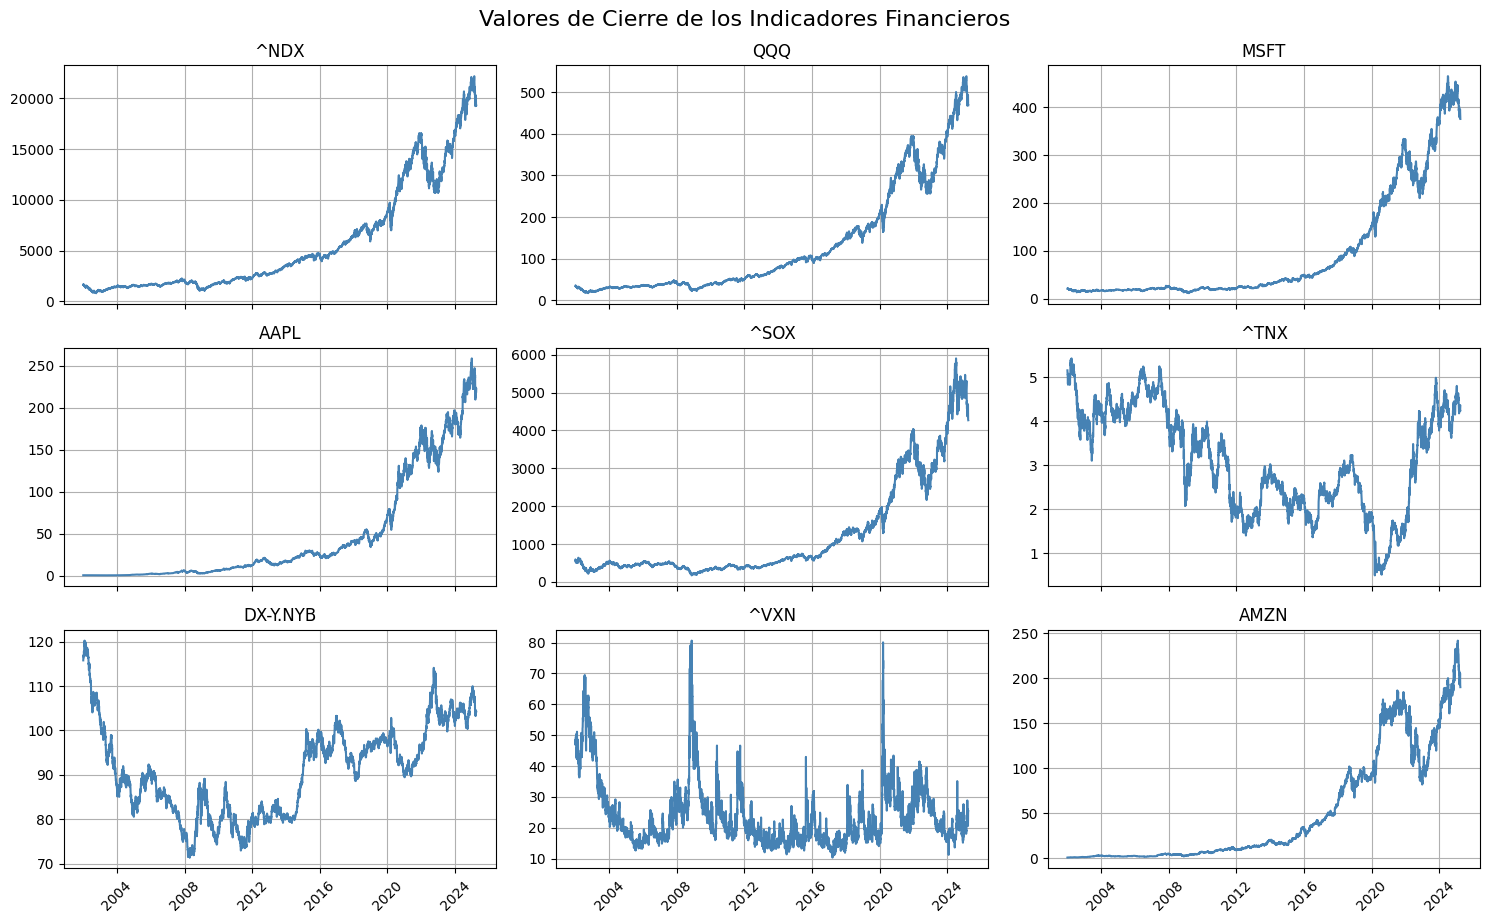

In [13]:
# Número de variables a considerar #
cols = df_close.columns
n_vars = len(cols)

# Se crea la figura #
n_cols = 3
n_rows = math.ceil(n_vars / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows), sharex=True)
axes = axes.flatten()

# Se grafica cada serie #
for i, col in enumerate(cols):
    axes[i].plot(df_close.index, df_close[col], label=col, color='steelblue')
    axes[i].set_title(col)
    axes[i].grid(True)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Valores de Cierre de los Indicadores Financieros', fontsize=16, y=1.02)
plt.show()

### 2.3. Distribución individual de cada activo

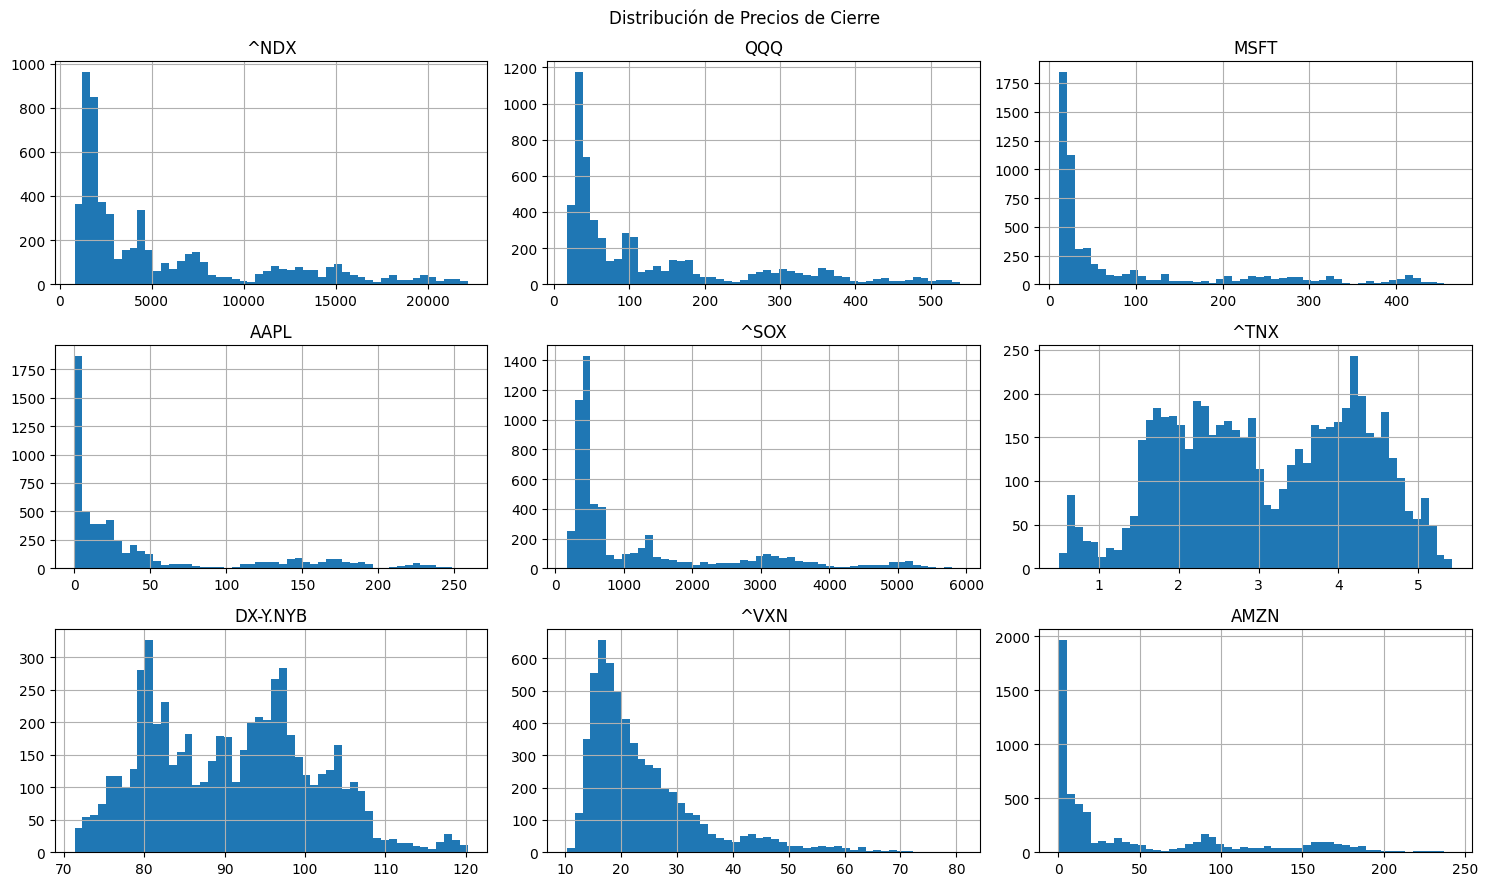

In [14]:
# Se construyen histogramas por cada activo con el fin de observar la distribución de los datos #
df_close.hist(bins = 50, figsize = (15, 9), layout = (3, 3))
plt.suptitle("Distribución de Precios de Cierre")
plt.tight_layout()
plt.show()

#### 2.3.1. Análisis de Normalidad de las Variables

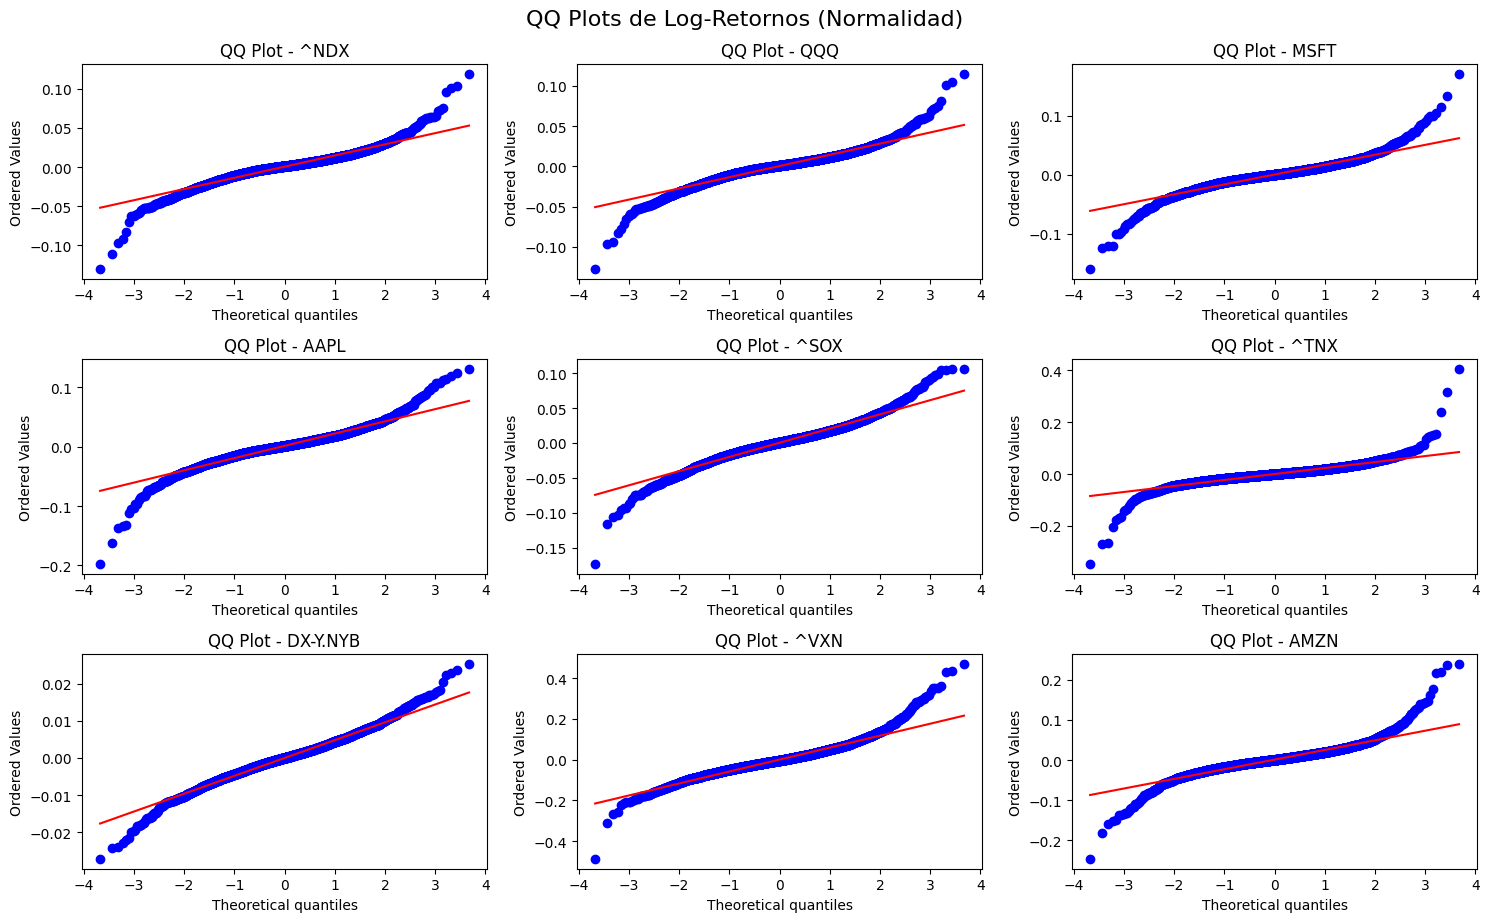

In [15]:
# Cálculo de log-retornos #
log_returns = np.log(df_close / df_close.shift(1)).dropna()

# QQ Plot por variable #
cols = log_returns.columns
n_vars = len(cols)
n_cols = 3
n_rows = math.ceil(n_vars / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols):
    stats.probplot(log_returns[col], dist="norm", plot=axes[i])
    axes[i].set_title(f"QQ Plot - {col}")

plt.tight_layout()
plt.suptitle("QQ Plots de Log-Retornos (Normalidad)", fontsize=16, y=1.02)
plt.show()

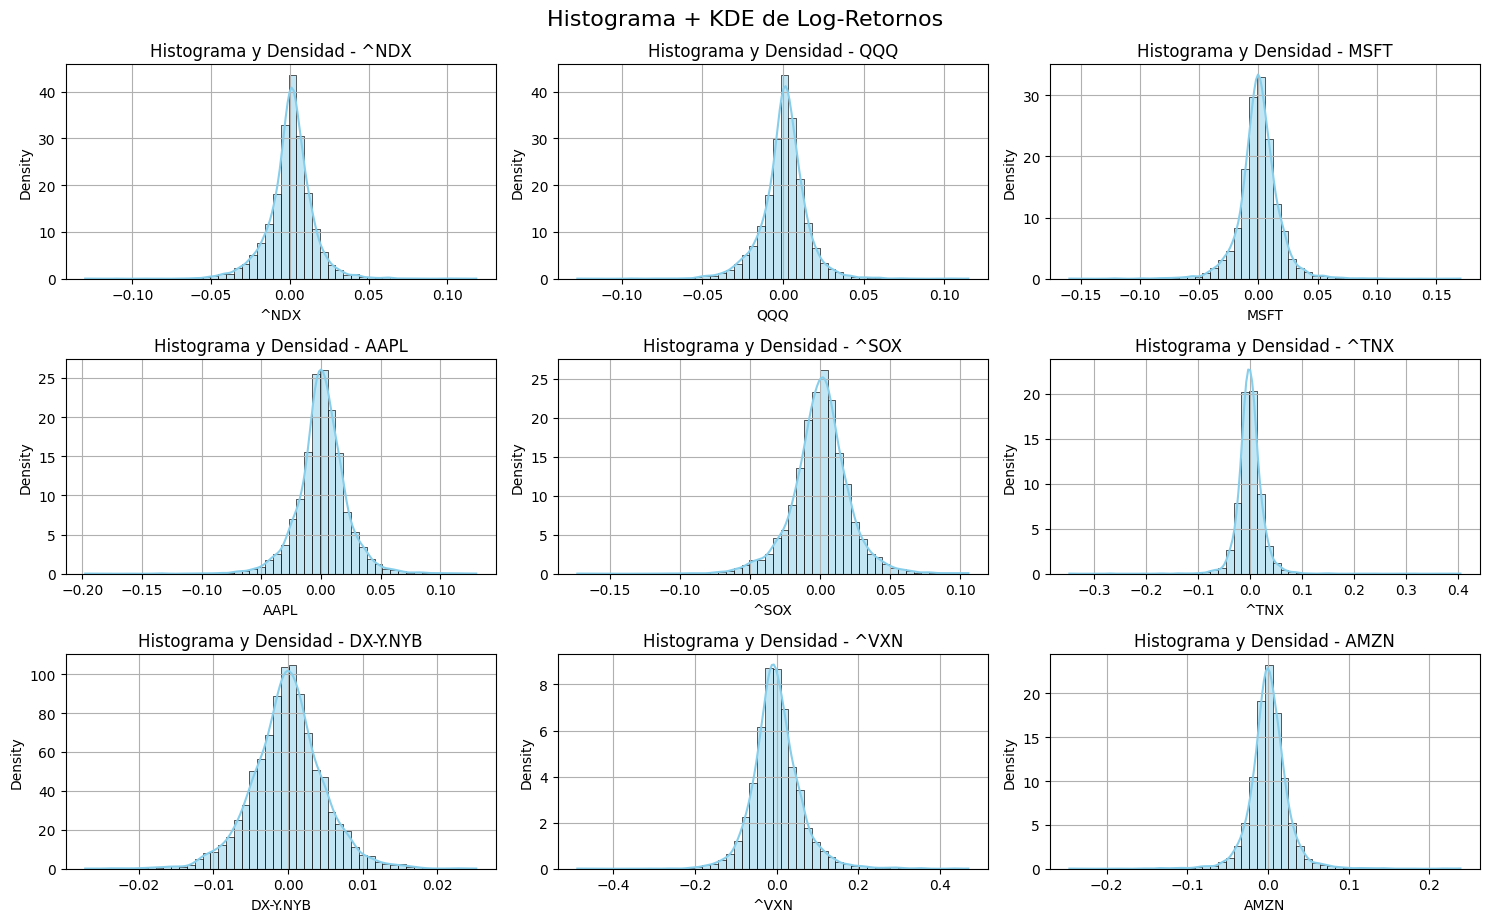

In [16]:
# Histograma + Curva de densidad #

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(log_returns[col], kde=True, stat='density', ax=axes[i], color="skyblue", bins=50)
    axes[i].set_title(f"Histograma y Densidad - {col}")
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Histograma + KDE de Log-Retornos", fontsize=16, y=1.02)
plt.show()

In [17]:
# Se inicializa una lista para almacenar los resultados #
normality_results = []

# Se itera por cada serie #
for col in log_returns.columns:
    serie = log_returns[col].dropna()

    # Test de Shapiro-Wilk
    shapiro_stat, shapiro_p = shapiro(serie)

    # Test de Jarque-Bera
    jb_stat, jb_p = jarque_bera(serie)

    normality_results.append({
        'Variable': col,
        'Shapiro-Wilk Stat': round(shapiro_stat, 4),
        'Shapiro-Wilk p': round(shapiro_p, 8),
        'Jarque-Bera Stat': round(jb_stat, 4),
        'Jarque-Bera p': round(jb_p, 4)
    })

# Se convierten los resultados a DataFrame #
normality_df = pd.DataFrame(normality_results)

# Se muestra la tabla ordenada por Shapiro p-value (más bajo = más lejos de normal)
normality_df.sort_values(by='Shapiro-Wilk p', inplace=True)
print(normality_df)

   Variable  Shapiro-Wilk Stat  Shapiro-Wilk p  Jarque-Bera Stat  \
0      ^NDX             0.9372             0.0         8872.6635   
1       QQQ             0.9393             0.0         8164.5061   
2      MSFT             0.9220             0.0        16471.1557   
3      AAPL             0.9457             0.0         7841.8763   
4      ^SOX             0.9663             0.0         2653.1984   
5      ^TNX             0.8546             0.0       253640.9590   
6  DX-Y.NYB             0.9848             0.0          739.7680   
7      ^VXN             0.9433             0.0         7407.3999   
8      AMZN             0.8972             0.0        30865.0812   

   Jarque-Bera p  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
5            0.0  
6            0.0  
7            0.0  
8            0.0  


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5848.
  res = hypotest_fun_out(*samples, **kwds)


### 2.4. Matriz de correlación entre activos

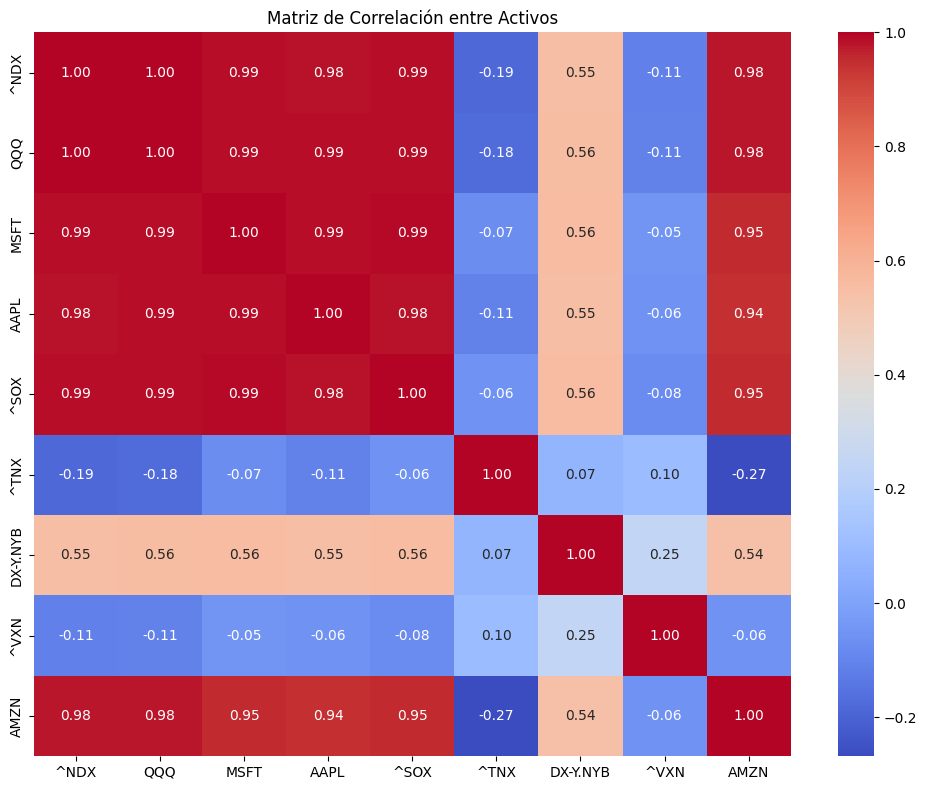

In [18]:
# Se grafica la matriz mediante un Heatmap #
plt.figure(figsize = (10, 8))
sns.heatmap(df_close.corr(), annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title('Matriz de Correlación entre Activos')
plt.tight_layout()
plt.show()

### 2.5. Construcción de Boxplots para ver outliers

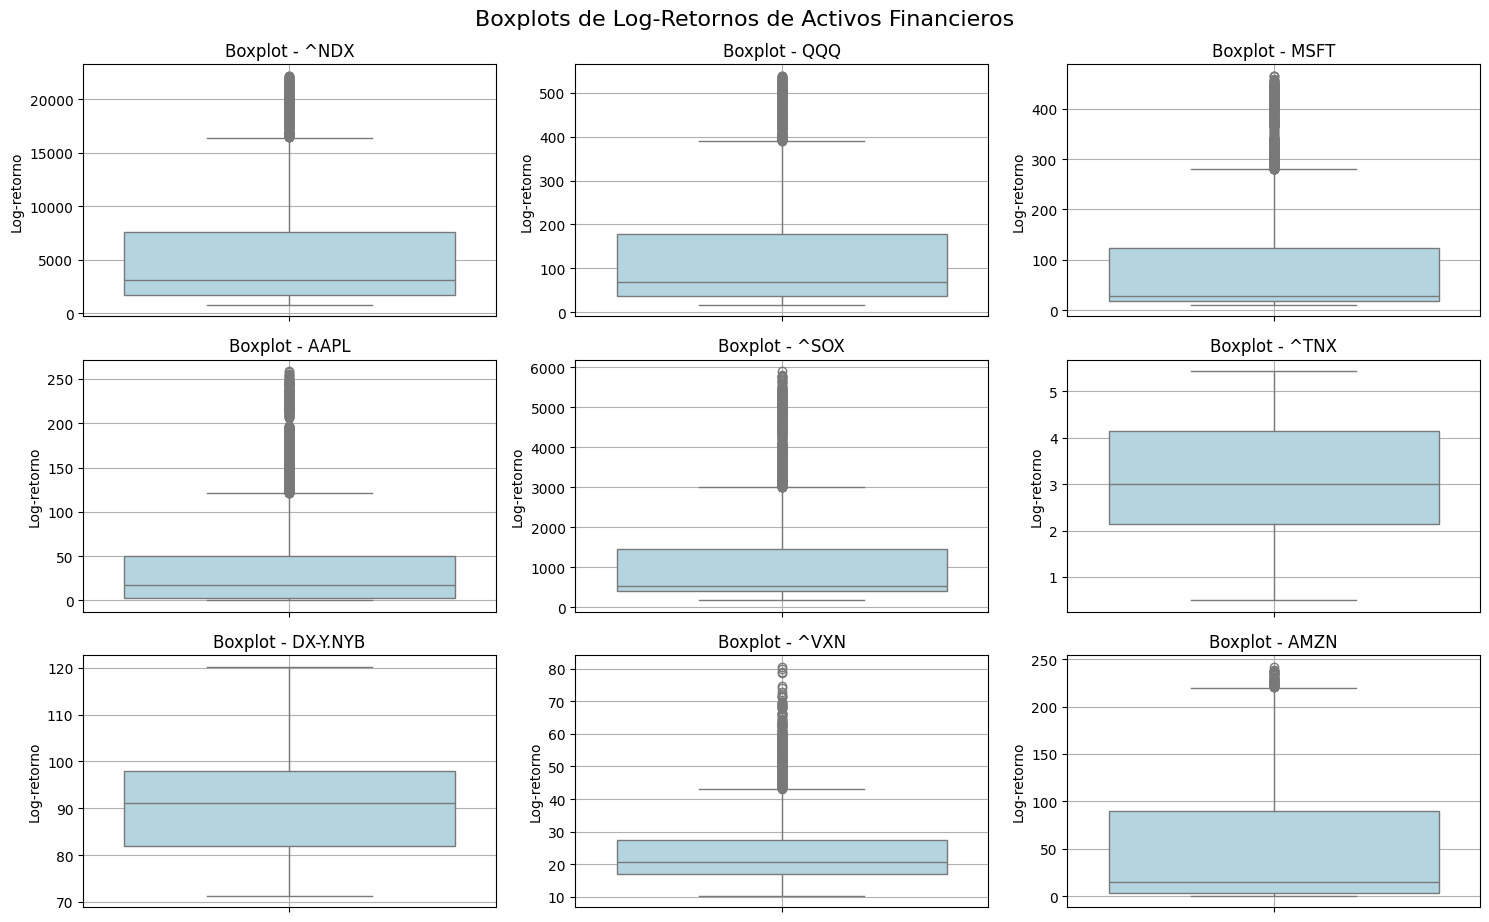

In [19]:
# Boxplot por variable #
fig, axes = plt.subplots(3, 3, figsize=(15, 9))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.boxplot(y=df_close[col], ax=axes[i], color="lightblue")
    axes[i].set_title(f"Boxplot - {col}")
    axes[i].set_ylabel('Log-retorno')
    axes[i].grid(True)

# Eliminar subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar layout
plt.tight_layout()
plt.suptitle("Boxplots de Log-Retornos de Activos Financieros", fontsize=16, y=1.02)
plt.show()


### 2.6. Análisis de Componentes Principales (PCA)

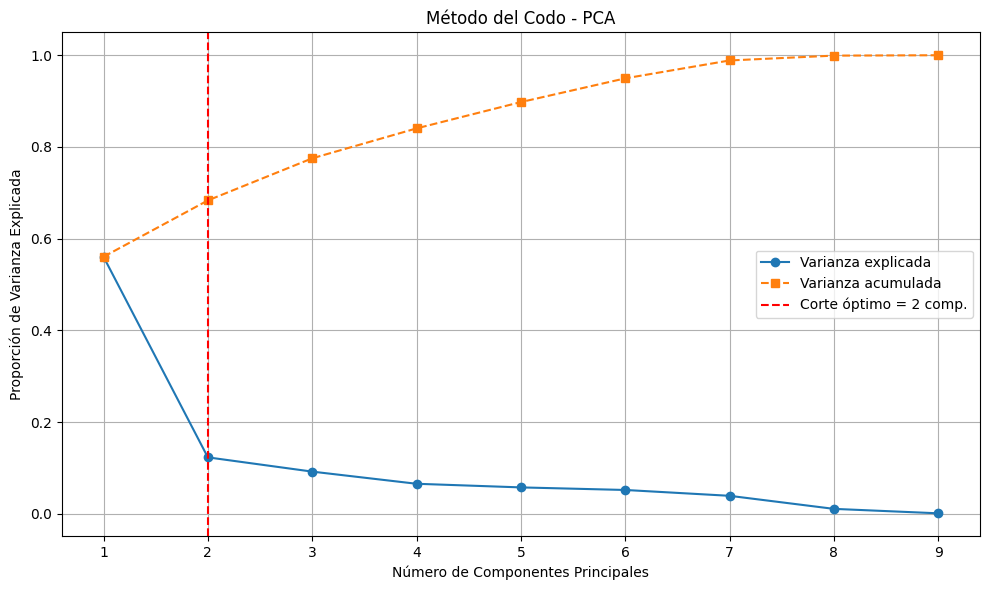

In [20]:
# Se calculan los log-retornos #
log_returns = np.log(df_close / df_close.shift(1)).dropna()

# Se estandarizan los datos #
scaler = StandardScaler()
log_returns_scaled = scaler.fit_transform(log_returns)

# Se aplica el PCA #
pca = PCA()
pca.fit(log_returns_scaled)

# Varianza explicada por componente #
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Scree plot (gráfico del codo) #
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_var) + 1), explained_var, 'o-', label='Varianza explicada')
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, 's--', label='Varianza acumulada')

optimal_components = np.argmax(cumulative_var >= 0.60) + 1  # por ejemplo, 60% de varianza acumulada
plt.axvline(x=optimal_components, color='red', linestyle='--', label=f'Corte óptimo = {optimal_components} comp.')

plt.title('Método del Codo - PCA')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Proporción de Varianza Explicada')
plt.xticks(range(1, len(explained_var) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
# Se crea la tabla resumen de la varianza explicada de cada componente #
pca_table = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(explained_var))],
    'Varianza Explicada': explained_var.round(4),
    'Varianza Acumulada': cumulative_var.round(4)
})

print(pca_table)

  Componente  Varianza Explicada  Varianza Acumulada
0        PC1              0.5604              0.5604
1        PC2              0.1229              0.6833
2        PC3              0.0918              0.7751
3        PC4              0.0653              0.8404
4        PC5              0.0574              0.8978
5        PC6              0.0518              0.9496
6        PC7              0.0390              0.9886
7        PC8              0.0106              0.9992
8        PC9              0.0008              1.0000


In [22]:
# Cargas principales de los activos #
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(explained_var))],
    index=log_returns.columns
)

# Se muestran solamente las primeras 5 componentes principales #
print("Cargas principales (loadings):")
print(loadings.iloc[:, :5].round(4))  # ajusta si deseas ver más o menos componentes

Cargas principales (loadings):
             PC1     PC2     PC3     PC4     PC5
^NDX     -0.4356 -0.0216 -0.0481  0.0406 -0.0200
QQQ      -0.4347 -0.0258 -0.0409  0.0380 -0.0159
MSFT     -0.3647 -0.0119 -0.0693  0.0207  0.1233
AAPL     -0.3335 -0.0120 -0.0746  0.3661 -0.7213
^SOX     -0.3891 -0.0171  0.0193  0.1381  0.0915
^TNX     -0.1402  0.6135  0.7405 -0.2026 -0.1148
DX-Y.NYB  0.0380  0.7863 -0.6008  0.1065  0.0813
^VXN      0.3336  0.0070 -0.0994 -0.2309 -0.6554
AMZN     -0.3053 -0.0595 -0.2569 -0.8589 -0.0781


Según los resultados, en donde se representa aproximadamente el 70% de la varianza explicada, se observa que este componente tiene pesos positivos fuertes en: el 'DX-Y.NYB' (Dólar) con +0.7863, y '^TNX' (Tasa del Tesoro 10 años) con el +0.6135, mencionando que este componente representa un factor macroeconómico relacionado con dólar fuerte y tasas altas, posiblemente ligado a expectativas de inflación o política monetaria.

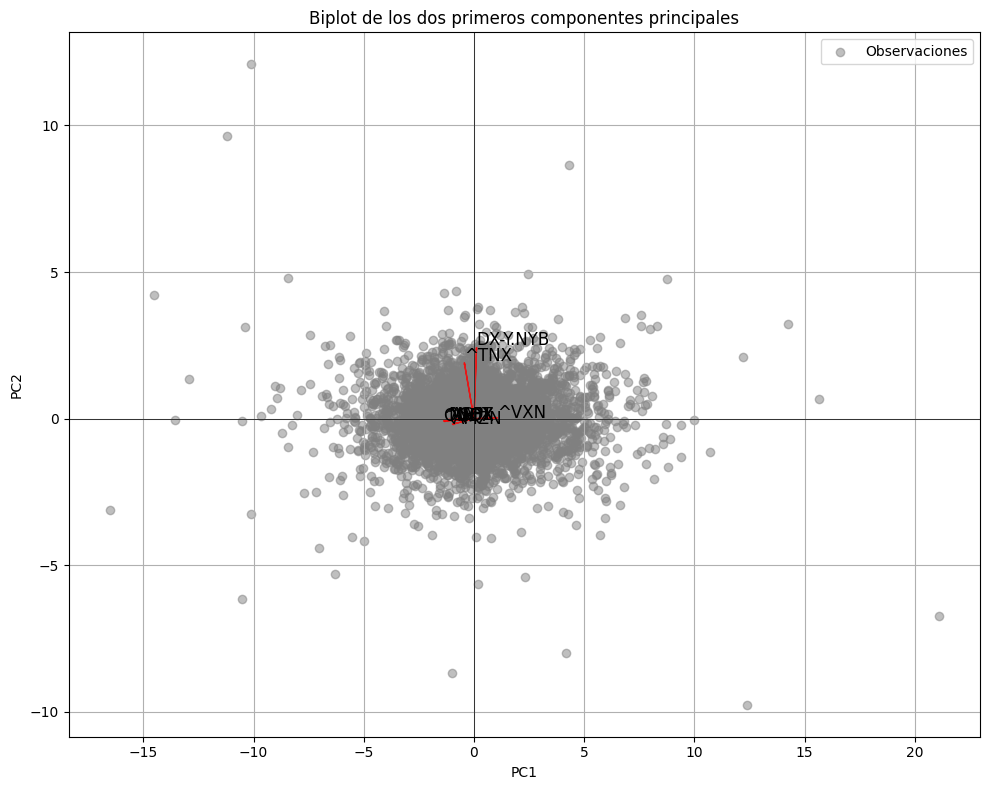

In [23]:
# Proyección de los datos en los dos primeros componentes
pca_2d = PCA(n_components=2)
proj = pca_2d.fit_transform(log_returns_scaled)

# Crear figura
plt.figure(figsize=(10, 8))
plt.scatter(proj[:, 0], proj[:, 1], alpha=0.5, color='grey', label='Observaciones')

# Añadir vectores (cargas)
for i, var in enumerate(log_returns.columns):
    plt.arrow(0, 0,
              pca_2d.components_[0, i] * 3,  # escala para visualización
              pca_2d.components_[1, i] * 3,
              color='red', alpha=0.8, head_width=0.05)
    plt.text(pca_2d.components_[0, i] * 3.2,
             pca_2d.components_[1, i] * 3.2,
             var, fontsize=12)

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Biplot de los dos primeros componentes principales")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 3. Descomposición de la serie temporal del Nasdaq-100

La descomposición de la serie ayudará a separar tendencia, estacionalidad y ruido, con el fin de evaluar si hay patrones estacionales o si la serie tiene un comportamiento más irregular y justificar si se debe aplicar modelos como SARIMA o si basta con un ARIMA simple.

In [24]:
# Indice NDX a Serie de tiempo #
ndx_series = df_close['^NDX'].copy()
ndx_series.index = pd.to_datetime(ndx_series.index)
# Se establece la frecuencia diaria de día hábil #
ndx_series = ndx_series.asfreq('B')

Se procede a hacer la descomposición con log-retornos o retornos simples, en donde el análisis se hace sobre los cambios relativos (%) y no sobre el nivel de precios. Se hace sobre los log-retornos, ya que suelen ser más estacionarios , lo cual es una propiedad importante en modelos estadísticos y que con esto, se pueden detectar patrones de volatilidad o cambios estructurales de una manera más fácil.

Dado que se está trabajando con modelos predictivos para el ^NDX, y que luego se usarán técnicas como modelos estadísticos o de ML, lo recomendable es trabajar con los log-retornos, garantizando mayor estacionariedad, un mejor comportamiento estadístico y una mayor comparabilidad entre activos.

<Figure size 1500x900 with 0 Axes>

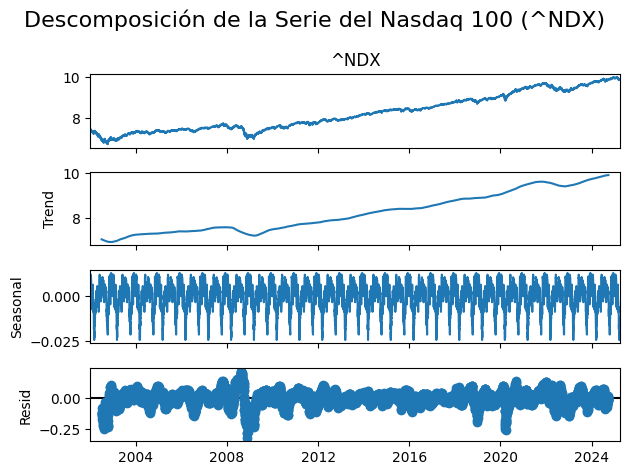

In [25]:
# Se calcula los log-retornos #
log_ndx = np.log(ndx_series)
log_ndx = log_ndx.dropna()

# Se hace la descomposición de la serie estableciendo un periodo de 252 hábiles #
decomp = seasonal_decompose(log_ndx, model='additive', period=252)

# Se visualiza la descomposición #
plt.figure(figsize=(15, 9))
decomp.plot()
plt.suptitle('Descomposición de la Serie del Nasdaq 100 (^NDX)', fontsize=16)
plt.tight_layout()
plt.show()

La descomposición de la serie logarítmica del índice del Nasdaq-100 reveló una estructura compuesta por una tendencia de crecimiento sostenido, una estacionalidad cíclica de baja magnitud, y residuos que capturan choques externos o eventos macroeconómicos puntuales. Esta estructura respalda la elección de modelos que consideren tanto componentes deterministas (como modelo SARIMA) y como no lineales (como redes neuronales o XGBoost), permitiendo una predicción más robusta de la dinámica del mercado tecnológico.

## 4. Modelado Predictivo

### 4.1. Modelos Clásicos

#### 4.1.1. Revisión de estacionariedad de la serie temporal para modelos clásicos

Con el fin de observar si una serie es estacionaria (requisito clave para ciertos modelos de series de tiempo como ARIMA o SARIMA), se puede usar el Dickey-Fuller test para verificar estacionaridad y aplicar diferenciación si es necesario.

In [26]:
# Lista de variables a analizar
variables = [ "^NDX", "QQQ", "MSFT", "AAPL", "^SOX", "^TNX", "DX-Y.NYB", "^VXN", "AMZN"]

# Asumiendo que 'df' es tu DataFrame con estas columnas #
results = {}

for var in variables:
    adf_test = adfuller(df_close[var].dropna())  # Eliminamos valores nulos antes de aplicar el test
    results[var] = {"ADF Statistic": adf_test[0], "p-value": adf_test[1]}

# Se muestran los resultados #
for var, result in results.items():
    print(f"{var}: ADF Statistic = {result['ADF Statistic']}, p-value = {result['p-value']}")

^NDX: ADF Statistic = 1.7575704513142723, p-value = 0.9982610458628443
QQQ: ADF Statistic = 1.9029512043608798, p-value = 0.9985327522248761
MSFT: ADF Statistic = 1.7422054222651142, p-value = 0.9982272308692826
AAPL: ADF Statistic = 1.9733476245232613, p-value = 0.9986373021366403
^SOX: ADF Statistic = 0.5266996482494254, p-value = 0.9856624116813842
^TNX: ADF Statistic = -2.0847276821294685, p-value = 0.25069985411380535
DX-Y.NYB: ADF Statistic = -2.45488925184719, p-value = 0.12683948653330768
^VXN: ADF Statistic = -4.931810402709503, p-value = 3.0228790424375403e-05
AMZN: ADF Statistic = 0.3982162827701901, p-value = 0.9814281144378928


Allí se observa que p-value de todos los activos, es mayor al 5%, lo que indica que ningún activo seleccionado es estacionaria y deberíamos aplicar diferenciación (diff()), a excepción del "^VXN. De esta manera, se realizará la diferenciación de todo el DataFrame para la construcción de los modelos clásicos.

In [27]:
# Diccionario con resultados del test ADF previamente calculados #
adf_results = {
    "^NDX": 0.9982610458628443, "QQQ": 0.9985327507335137, "MSFT": 0.9982272311177374,
    "AAPL": 0.9986373020558318, "^SOX": 0.9856624116813842, "^TNX": 0.25069985411380535,
    "DX-Y.NYB": 0.12683948653330768, "^VXN": 3.0228790424375403e-05, "AMZN": 0.9814281144378928
}

# Lista de variables no estacionarias (p-value > 0.05) #
variables_no_estacionarias = [var for var, p_value in adf_results.items() if p_value > 0.05]
# Lista de variables estacionarias #
variables_estacionarias = [var for var in adf_results if var not in variables_no_estacionarias]

# Se crea un nuevo DataFrame que contenga las variables diferenciadas y las originales que ya son estacionarias #
df_diff = pd.DataFrame()

# Aplicar diferenciación en las variables necesarias #
for var in variables_no_estacionarias:
    df_diff[f"{var}"] = df_close[var].diff().dropna()
    print(f"Diferenciación aplicada a {var} (p-value = {adf_results[var]})")

# Incluir las variables que ya son estacionarias sin modificar #
for var in variables_estacionarias:
    df_diff[var] = df_close[var]
    print(f"{var} es estacionaria y se mantiene sin cambios (p-value = {adf_results[var]})")

# Mostrar las primeras filas para verificar la transformación
print(df_diff.head())

Diferenciación aplicada a ^NDX (p-value = 0.9982610458628443)
Diferenciación aplicada a QQQ (p-value = 0.9985327507335137)
Diferenciación aplicada a MSFT (p-value = 0.9982272311177374)
Diferenciación aplicada a AAPL (p-value = 0.9986373020558318)
Diferenciación aplicada a ^SOX (p-value = 0.9856624116813842)
Diferenciación aplicada a ^TNX (p-value = 0.25069985411380535)
Diferenciación aplicada a DX-Y.NYB (p-value = 0.12683948653330768)
Diferenciación aplicada a AMZN (p-value = 0.9814281144378928)
^VXN es estacionaria y se mantiene sin cambios (p-value = 3.0228790424375403e-05)
                 ^NDX       QQQ      MSFT      AAPL       ^SOX   ^TNX  \
Date                                                                    
2002-01-03  56.270020  1.178207  0.672472  0.004213  45.158142 -0.037   
2002-01-04   8.369995  0.144123 -0.101324  0.001656  -0.729614  0.021   
2002-01-07 -25.200073 -0.389931 -0.104408 -0.011887  -9.645386 -0.084   
2002-01-08  16.750000  0.237343  0.251799 -0.004364 

In [28]:
# Lista de variables a analizar
variables2 = [ "^NDX", "QQQ", "MSFT", "AAPL", "^SOX", "^TNX", "DX-Y.NYB", "^VXN", "AMZN"]

# Asumiendo que 'df' es tu DataFrame con estas columnas #
results2 = {}

for var in variables2:
    adf_test = adfuller(df_diff[var].dropna())  # Eliminamos valores nulos antes de aplicar el test
    results2[var] = {"ADF Statistic": adf_test[0], "p-value": adf_test[1]}

# Se muestran los resultados #
for var, result in results2.items():
    print(f"{var}: ADF Statistic = {result['ADF Statistic']}, p-value = {result['p-value']}")

^NDX: ADF Statistic = -15.31962865861789, p-value = 4.080882741449593e-28
QQQ: ADF Statistic = -15.288553527481197, p-value = 4.475872756830536e-28
MSFT: ADF Statistic = -16.53787809845494, p-value = 1.9962086854457526e-29
AAPL: ADF Statistic = -14.97129780107929, p-value = 1.1990750441255164e-27
^SOX: ADF Statistic = -12.890566264844667, p-value = 4.457852609637029e-24
^TNX: ADF Statistic = -57.286237204064605, p-value = 0.0
DX-Y.NYB: ADF Statistic = -23.202762089235982, p-value = 0.0
^VXN: ADF Statistic = -4.959540646114358, p-value = 2.6670306004164072e-05
AMZN: ADF Statistic = -13.044911196773963, p-value = 2.2019839962830747e-24


Luego de hacer nuevamene el test, se confirma que ya las series de activos seleccionadas son estacionarias y se puede seguir con el modelo ARIMA.

#### 4.1.2. Modelo ARIMA

Este modelo es clave para capturar patrones en series temporales, como tendencias y autocorrelaciones. En primer lugar, se seleccionan los parámetros (p, d, q). Para determinar estos valores adecuados de p, d y q, se sigue esta lógica:

- d (Diferenciación): Como ya se hizo una diferenciación en las series que no eran estacionarias., se usa d = 1.

- p y q (Orden autorregresivo y media móvil): Para los valores p y q se usan los gráficos de Autocorrelación (ACF) y Autocorrelación Parcial (PACF) para estimar estos parámetros.

In [29]:
# Se define la serie diferenciada como objetivo #
serie_ndx = df_diff["^NDX"].dropna()

# División de los datos #
train_size = int(len(serie_ndx) * 0.8)
ndx_train, ndx_test = serie_ndx[:train_size], serie_ndx[train_size:]

print(f"Tamaño del conjunto de entrenamiento: {len(ndx_train)}")
print(f"Tamaño del conjunto de prueba: {len(ndx_test)}")

Tamaño del conjunto de entrenamiento: 4678
Tamaño del conjunto de prueba: 1170


#### * Autocorrelación (ACF) y Autocorrelación Parcial (PACF) *

Ambos son fundamentales para poder identificar el orden del modelo ARIMA, en donde el ACF sugiere el orden de la parte MA (o valor q), mientras que el PACF indica el orden de la parte AR (o valor p). Por otro lado, estos son fundamentales para ver si la serie tiene memoria temporal, es decir, si los valores pasados ayudan a predecir el futuro.

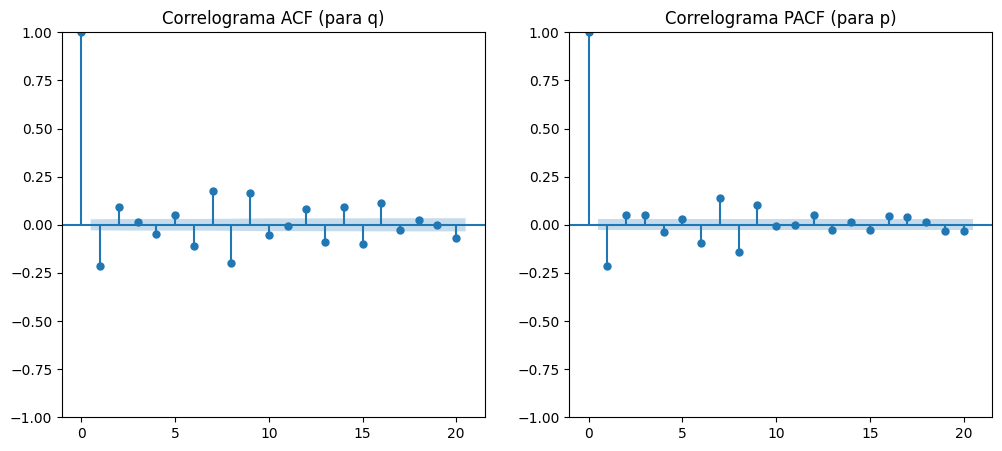

In [30]:
# Graficos ACF y PACF #
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sm.graphics.tsa.plot_acf(ndx_train, ax=ax[0], lags=20)  # Correlograma ACF (q)
sm.graphics.tsa.plot_pacf(ndx_train, ax=ax[1], lags=20)  # Correlograma PACF (p)
ax[0].set_title("Correlograma ACF (para q)")
ax[1].set_title("Correlograma PACF (para p)")
plt.show()

Según estos gráficos ACF y PACF, se observa que en el ACF, el primer rezago tiene autocorrelación significativa, mientras que los siguientes rezagos están dentro del intervalo de confianza, lo que sugiere que q = 1 puede ser una buena elección.

Por otro lado, en el PACF se observa que el primer rezago es significativo y los demás caen dentro del intervalo de confianza, lo que sugiere que p = 1 es adecuado.

Por esto, los valores recomendados para el modelo ARIMA serían p = 1, d = 1, q = 1.

In [31]:
# Se definen los parámetros según ACF y PACF anterior #
p, d, q = 1,1,1

# Se entrena el modelo ARIMA con los datos de entrenamiento #
modelo_arima = ARIMA(ndx_train, order=(p, d, q))
resultado_arima = modelo_arima.fit()

# Se muestra el resumen del modelo #
print(resultado_arima.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   ^NDX   No. Observations:                 4678
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -25373.116
Date:                Wed, 23 Apr 2025   AIC                          50752.233
Time:                        11:48:22   BIC                          50771.584
Sample:                             0   HQIC                         50759.038
                               - 4678                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2171      0.003    -65.804      0.000      -0.224      -0.211
ma.L1         -0.9983      0.001  -1093.033      0.000      -1.000      -0.996
sigma2      3013.9113     14.406    209.217      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


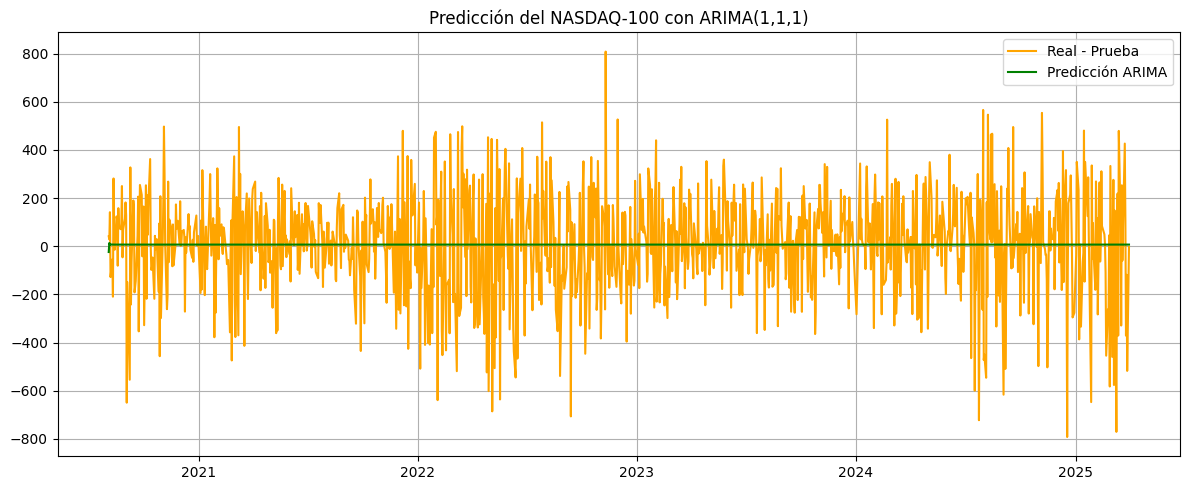

In [32]:
# Se realizan las predicciones en el conjunto de prueba #
pred_arima = resultado_arima.forecast(steps=len(ndx_test))

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
#plt.plot(ndx_train, label='Entrenamiento')
plt.plot(ndx_test, label='Real - Prueba', color='orange')
plt.plot(ndx_test.index, pred_arima, label='Predicción ARIMA', color='green')
plt.title('Predicción del NASDAQ-100 con ARIMA(1,1,1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Ahora, se calcularán las principales métricas de evaluación para el modelo ARIMA ajustado con auto_arima sobre la serie del Nasdaq. Estas son el RMSE (Root Mean Squared Error), el MAE (Mean Absolute Error), el R^2 (Coeficiente de determinación) y el AIC y BIC (de la parte entrenada del modelo).

In [33]:
# Evaluación del modelo #
print(f"Evaluación del modelo ARIMA(1,1,1) - Serie NDX Diferenciada:")

# RMSE #
rmse = np.sqrt(mean_squared_error(ndx_test, pred_arima))
print(f"RMSE: {rmse:.4f}")

# MAE #
mae = mean_absolute_error(ndx_test, pred_arima)
print(f"MAE: {mae:.4f}")

# R^2 #
r2 = r2_score(ndx_test, pred_arima)
print(f"R^2: {r2:.4f}")

# AIC y BIC solo si el modelo los tiene #
aic = resultado_arima.aic
print(f"AIC:  {aic:.2f}")
bic = resultado_arima.bic
print(f"BIC:  {bic:.2f}")

# Se guardan los resultados #
resultados_ARIMA = {
    "modelo": "ARIMA(1,1,1)",
    "rmse": rmse,
    "mae": mae,
    "r2": r2,
    "aic": aic,
    "bic": bic
}

Evaluación del modelo ARIMA(1,1,1) - Serie NDX Diferenciada:
RMSE: 208.9222
MAE: 157.9032
R^2: -0.0001
AIC:  50752.23
BIC:  50771.58


Estos resultados sugieren que el modelo ARIMA no está capturando correctamente la dinámica de la serie temporal diferenciada al tener RMSE alto (208.92) y un MAE alto (157.90). Estos valores indican que el modelo está cometiendo errores significativos al predecir los valores futuros, ya que un buen modelo debería tener RMSE y MAE bajos, lo que significaría que las predicciones están más cerca de los valores reales.

Adicionalmente, se tiene un valor de R^2 negativo (-0.0001), lo que significa que el modelo es peor que simplemente tomar el promedio de la serie de prueba, y no está explicando la variabilidad de los datos, lo cual podría estar generando predicciones demasiado planas o poco informativas.

Por otro lado, según el gráfico, las predicciones no reflejan la volatilidad real del índice, lo que indica que el modelo podría estar demasiado restringido o no estar considerando cambios bruscos en la serie.

Es por ello que se procede con el ajuste de un modelo ARIMAX con las variables exógenas.

#### 4.1.3. Modelo ARIMAX

Se hace un modelado con ARIMAX, que es básicamente un ARIMA que incluye variables exógenas, en este caso otros activos o indicadores financieros, con el fin de mejorar la predicción del índice ^NDX.

In [34]:
# Se define la variable objetivo y las exógenas #
y = df_diff["^NDX"].dropna()  # Variable dependiente
X = df_diff.drop(columns=["^NDX"]).dropna()  # Variables exógenas

# División de conjuntos (80% entrenamiento, 20% prueba) #
train_size = int(len(y) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

Del ACF y PACF se encontró que los mejores valores para p y q son 1, además de que el valor de d es igual a 1 también por la diferenciación hecha. De esta manera, se utilizan estos mismos valores

In [35]:
# Se definen los parámetros óptimos #
p, d, q = 1, 1, 1

# Se ajusta el modelo ARIMAX con variables exógenas #
modelo_arimax = ARIMA(y_train, order=(p, d, q), exog = X_train)
resultado_arimax = modelo_arimax.fit()

# Resumen del modelo #
print(resultado_arimax.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   ^NDX   No. Observations:                 4678
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -13462.195
Date:                Wed, 23 Apr 2025   AIC                          26946.390
Time:                        11:48:58   BIC                          27017.345
Sample:                             0   HQIC                         26971.343
                               - 4678                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
QQQ           42.4396      0.135    314.265      0.000      42.175      42.704
MSFT           0.5921      0.069      8.639      0.000       0.458       0.726
AAPL          -0.9814      0.124     -7.934      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


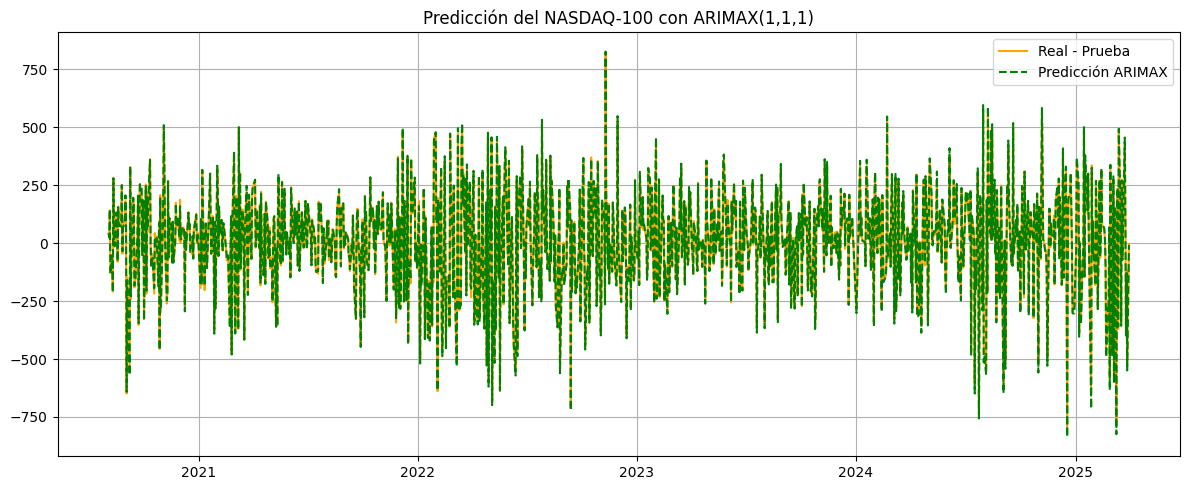

In [36]:
# Se realizan las predicciones en el conjunto de prueba #
pred_arimax = resultado_arimax.forecast(steps=len(y_test), exog=X_test)

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
#plt.plot(y_train, label='Entrenamiento')
plt.plot(y_test, label='Real - Prueba', color='orange')
plt.plot(y_test.index, pred_arimax, label='Predicción ARIMAX', linestyle="dashed", color='green')
plt.title('Predicción del NASDAQ-100 con ARIMAX(1,1,1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# Evaluación del modelo #
print(f"Evaluación del modelo ARIMAX(1,1,1) - DataFrame Diferenciado:")

# RMSE #
rmse = np.sqrt(mean_squared_error(y_test, pred_arimax))
print(f"RMSE: {rmse:.4f}")

# MAE #
mae = mean_absolute_error(y_test, pred_arimax)
print(f"MAE: {mae:.4f}")

# R^2 #
r2 = r2_score(y_test, pred_arimax)
print(f"R^2: {r2:.4f}")

# AIC y BIC solo si el modelo los tiene #
aic = resultado_arimax.aic
print(f"AIC:  {aic:.2f}")
bic = resultado_arimax.bic
print(f"BIC:  {bic:.2f}")

# Se guardan los resultados #
resultados_ARIMAX = {
    "modelo": "ARIMAX(1,1,1)",
    "rmse": rmse,
    "mae": mae,
    "r2": r2,
    "aic": aic,
    "bic": bic
}

Evaluación del modelo ARIMAX(1,1,1) - DataFrame Diferenciado:
RMSE: 11.8572
MAE: 8.4715
R^2: 0.9968
AIC:  26946.39
BIC:  27017.34


De esta manera se observa que las variables exógenas si aportan información predictiva adicional, lo que es posible que los activos seleccionados están tan correlacionados con ^NDX que no añaden información nueva respecto a la que ya tiene el propio ^NDX.

Estos resultados indican que el modelo ARIMAX(1,1,1) está funcionando muy bien en términos de precisión predictiva, al tener por ejemplo un valor de R^2 = 0.9968, lo que sería un excelente ajuste e indica que el modelo explica casi toda la variabilidad de la serie diferenciada de ^NDX y que las variables exógenas están agregando información valiosa, mejorando la predicción sobre un simple ARIMA.

Por otro lado, se tiene un valor RMSE = 11.76 y MAE = 8.40 lo que sería un erros bajo, que comparado con el modelo ARIMA puro, los errores son considerablemente menores y sugiere que las predicciones siguen muy bien la dinámica del índice NASDAQ-100.

Sin embargo, se tienen valores de AIC y BIC relativamente altos (26950.84 / 27021.79), lo que indica que el modelo es complejo, pero el bajo RMSE y alto R^2 justifican su uso.

Se ajustará ahora un modelo SARIMA.

#### 4.1.4. Modelo SARIMA

Al realizar la construcción de un modelo SARIMA (Seasonal ARIMA), este permitirá capturar patrones estacionales, además de las tendencias y dependencias temporales que ARIMA ya modela, lo que es especialmente útil en este caso, ya que se observaron patrones que se repiten anualmente en el índice ^NDX.

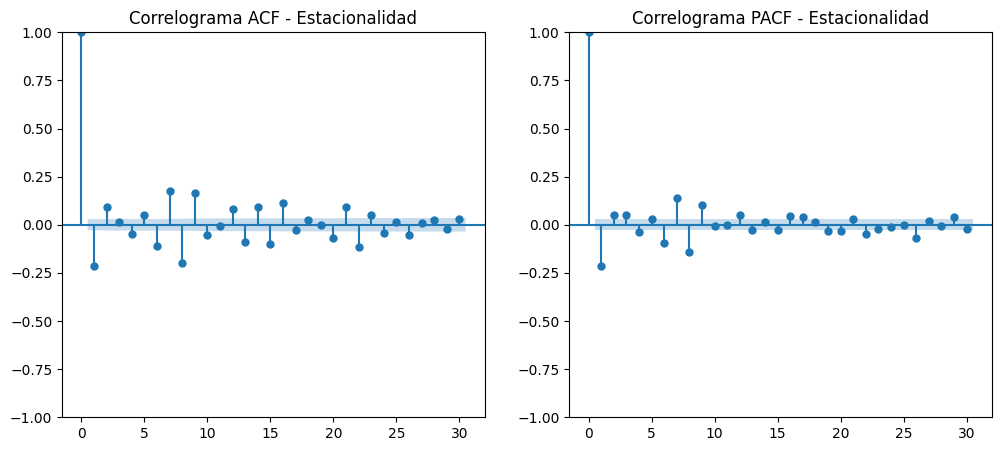

In [38]:
# En primer lugar se grafican el ACF y el PACF para identificar estacionalidad #
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sm.graphics.tsa.plot_acf(ndx_train.dropna(), ax=ax[0], lags=30)
sm.graphics.tsa.plot_pacf(ndx_train.dropna(), ax=ax[1], lags=30)
ax[0].set_title("Correlograma ACF - Estacionalidad")
ax[1].set_title("Correlograma PACF - Estacionalidad")
plt.show()

In [39]:
# Se definen los parámetros del modelo SARIMA #
p, d, q = 1, 1, 1  # Valores según ACF/PACF
P, D, Q, s = 1, 1, 1, 21  # Estacionalidad detectada leve

# Ajustar el modelo SARIMA #
modelo_sarima = SARIMAX(ndx_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
resultado_sarima = modelo_sarima.fit()

# Mostrar resumen del modelo
print(resultado_sarima.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                               ^NDX   No. Observations:                 4678
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 21)   Log Likelihood              -25304.627
Date:                            Wed, 23 Apr 2025   AIC                          50619.255
Time:                                    11:50:36   BIC                          50651.484
Sample:                                         0   HQIC                         50630.592
                                           - 4678                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2060      0.003    -62.498      0.000      -0.212      -0.200
ma.L1         -0.9993      0.002   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


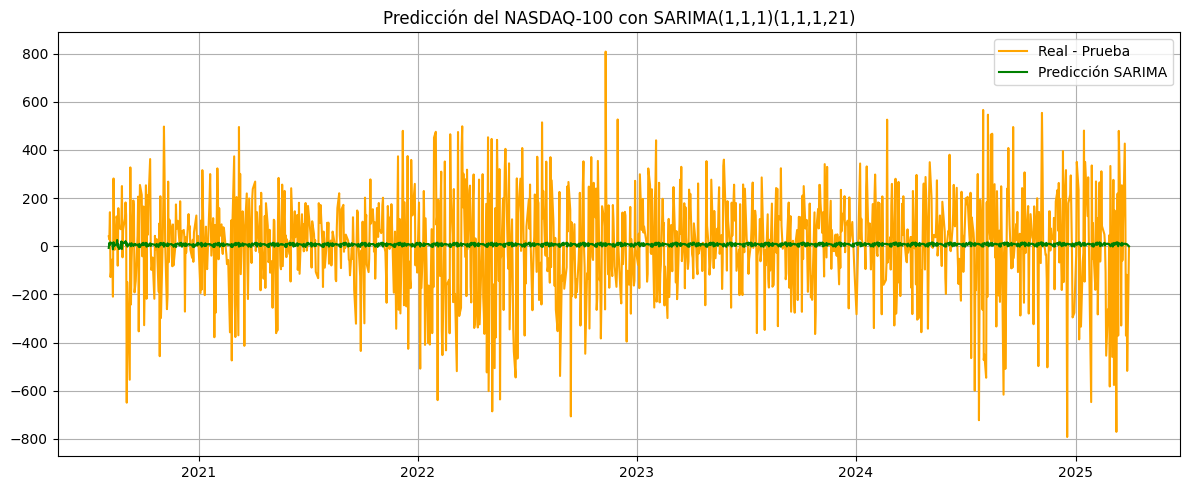

In [41]:
# Se realizan las predicciones en el conjunto de prueba #
pred_sarima = resultado_sarima.forecast(steps=len(ndx_test))

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
#plt.plot(ndx_train, label='Entrenamiento')
plt.plot(ndx_test, label='Real - Prueba', color='orange')
plt.plot(ndx_test.index, pred_sarima, label='Predicción SARIMA', color='green')
plt.title('Predicción del NASDAQ-100 con SARIMA(1,1,1)(1,1,1,21)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
# Evaluación del modelo #
print(f"Evaluación del modelo SARIMA(1,1,1)(1,1,1,12) - Serie NDX Diferenciada:")

# RMSE #
rmse = np.sqrt(mean_squared_error(ndx_test, pred_sarima))
print(f"RMSE: {rmse:.4f}")

# MAE #
mae = mean_absolute_error(ndx_test, pred_sarima)
print(f"MAE: {mae:.4f}")

# R^2 #
r2 = r2_score(ndx_test, pred_sarima)
print(f"R^2: {r2:.4f}")

# AIC y BIC solo si el modelo los tiene #
aic = resultado_sarima.aic
print(f"AIC:  {aic:.2f}")
bic = resultado_sarima.bic
print(f"BIC:  {bic:.2f}")

# Se guardan los resultados #
resultados_SARIMA = {
    "modelo": "SARIMA(1,1,1,12)(1,1,1)",
    "rmse": rmse,
    "mae": mae,
    "r2": r2,
    "aic": aic,
    "bic": bic
}

Evaluación del modelo SARIMA(1,1,1)(1,1,1,12) - Serie NDX Diferenciada:
RMSE: 209.0163
MAE: 157.9255
R^2: -0.0010
AIC:  50619.25
BIC:  50651.48


Estos resultados indican que el modelo SARIMA(1,1,1)(1,1,1,12) no está capturando adecuadamente la estructura de la serie diferenciada del ^NDX, al tener un RMSE alto (208.9114) y MAE alto (157.9941), indicando que el modelo tiene errores significativos en sus predicciones, lo que sugiere que no está ajustando bien los datos reales. Un buen modelo tendría un RMSE y MAE más bajos, mostrando que las predicciones están más cerca de los valores reales (como el ARIMAX).

Este modelo tiene R^2 = 0.0000, lo que indica que no tiene una capacidad explicativa y básicamente el modelo no está explicando ninguna variabilidad de la serie de datos, ni mejorando con respecto a una simple media constante. Esto indica que la estacionalidad introducida en SARIMA no es relevante o que la serie no presenta un patrón estacional significativo.

Por último, se tienen valores AIC/BIC muy altos (50675.62 / 50707.86), lo que sugieren que el modelo es complejo, pero no mejora el ajuste.

Estos resultados concluyen que la estacionalidad no parece tener un impacto significativo.

#### 4.1.5. Modelo GARCH

El modelo GARCH (Generalized Autoregressive Conditional Heteroskedasticity) es usado para capturar y predecir la volatilidad de una serie financiera, como el NASDAQ-100 (^NDX), que a diferencia de ARIMA, que modela el nivel de la serie, GARCH modela la varianza condicional, es decir, cómo varía la volatilidad a lo largo del tiempo.

Como se vio antes del ajuste del modelo ARIMA, se concluyo que la serie quedo diferenciada, de manera que se vuelve estacionaria, y así, es posible ajustar el modelo GARCH.

In [43]:
# Se define el modelo GARCH sobre la serie de log-retornos #
modelo_garch = arch_model(ndx_train.dropna(), vol="Garch", p=1, q=1)

# Se ajusta el modelo #
resultado_garch = modelo_garch.fit()

# Se muestra el resumen del modelo #
print(resultado_garch.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 135033.33981652278
Iteration:      2,   Func. Count:     13,   Neg. LLF: 32998.923332391496
Iteration:      3,   Func. Count:     19,   Neg. LLF: 22936.522026575807
Iteration:      4,   Func. Count:     25,   Neg. LLF: 23453.952221680756
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1402053746.3237908
Iteration:      6,   Func. Count:     37,   Neg. LLF: 23021.82754623206
Iteration:      7,   Func. Count:     43,   Neg. LLF: 22902.64779290092
Iteration:      8,   Func. Count:     49,   Neg. LLF: 22895.213558644413
Iteration:      9,   Func. Count:     55,   Neg. LLF: 22832.780138595524
Iteration:     10,   Func. Count:     61,   Neg. LLF: 22819.78822201129
Iteration:     11,   Func. Count:     67,   Neg. LLF: 22820.024710295023
Iteration:     12,   Func. Count:     73,   Neg. LLF: 22798.315151750397
Iteration:     13,   Func. Count:     78,   Neg. LLF: 22798.28048766015
Iteration:     14,   Func. Count:     83,   Neg. LLF: 2

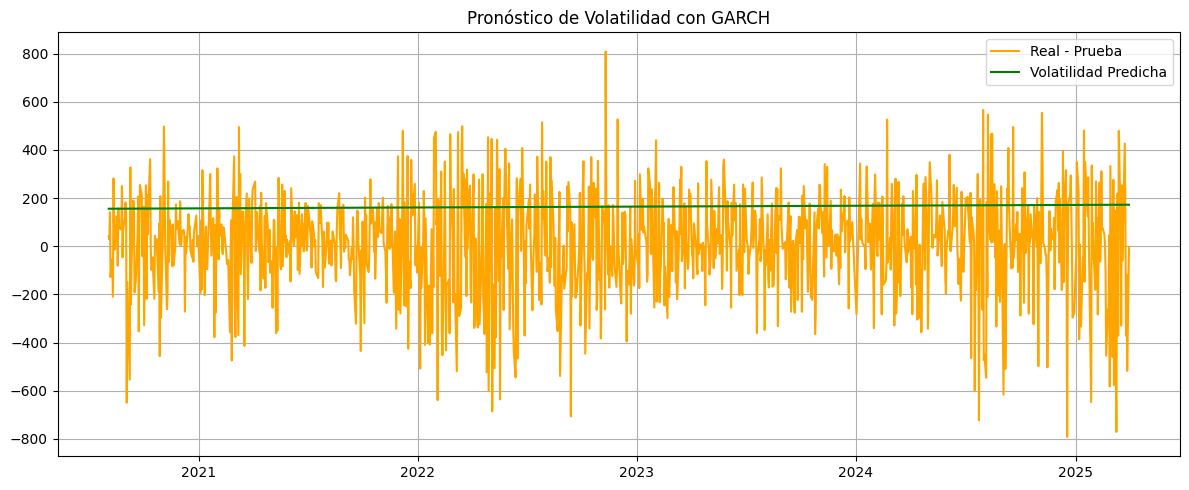

In [44]:
# Se realizan las predicciones en el conjunto de prueba #
pred_garch = resultado_garch.forecast(horizon=len(ndx_test))

# Se extrae la desviación estándar pronosticada (volatilidad) #
volatilidad_predicha = np.sqrt(pred_garch.variance.values[-1, :])

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
#plt.plot(ndx_train, label='Entrenamiento')
plt.plot(ndx_test.index, ndx_test, label='Real - Prueba', color='orange')
plt.plot(ndx_test.index, volatilidad_predicha, label='Volatilidad Predicha', color='green')
plt.title('Pronóstico de Volatilidad con GARCH')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
# Evaluación del modelo #
print(f"Evaluación del modelo GARCH(1,1) - Serie NDX Diferenciada:")

# RMSE #
rmse = np.sqrt(mean_squared_error(np.abs(ndx_test), volatilidad_predicha))
print(f"RMSE: {rmse:.4f}")

# MAE #
mae = mean_absolute_error(np.abs(ndx_test), volatilidad_predicha)
print(f"MAE: {mae:.4f}")

# R^2 #
r2 = 0
print(f"R^2: {r2:.4f}")

# AIC y BIC solo si el modelo los tiene #
aic = resultado_garch.aic
print(f"AIC:  {aic:.2f}")
bic = resultado_garch.bic
print(f"BIC:  {bic:.2f}")

# Se guardan los resultados #
resultados_GARCH = {
    "modelo": "GARCH(1,1)",
    "rmse": rmse,
    "mae": mae,
    "r2": r2,
    "aic": aic,
    "bic": bic
}

Evaluación del modelo GARCH(1,1) - Serie NDX Diferenciada:
RMSE: 136.2165
MAE: 107.5029
R^2: 0.0000
AIC:  45604.54
BIC:  45630.34


### 4.2. Modelos de Machine Learning

#### 4.2.1. Modelo de Regresión Lineal Simple en función del tiempo

Para entrar al mundo multivariado con machine learning, se comenzará con el modelo clásico de Regresión Lineal Simple, lo cual es ideal para establecer una línea base. Sin embargo, este primero se ajustará para la variable del NASDAQ-100 en función del tiempo.

In [46]:
# En primer lugar, se convierte la columna 'Fecha' en formato numérico desde el inicio #
data = df_close.copy()

# Se crea una columna de tiempo basada en el índice del DataFrame #
data["Tiempo"] = range(1, len(data) + 1)

##### * Validación de supuestos *

En primer lugar se hará la validación de supuestos, empezando por el supuesto de linealidad:

In [47]:
# Se ajusta el modelo preliminar #
X = sm.add_constant(data["Tiempo"])
modelo_temp = sm.OLS(data["^NDX"], X).fit()
residuos = modelo_temp.resid
data['residuos'] = modelo_temp.resid
data['ajustado'] = modelo_temp.fittedvalues

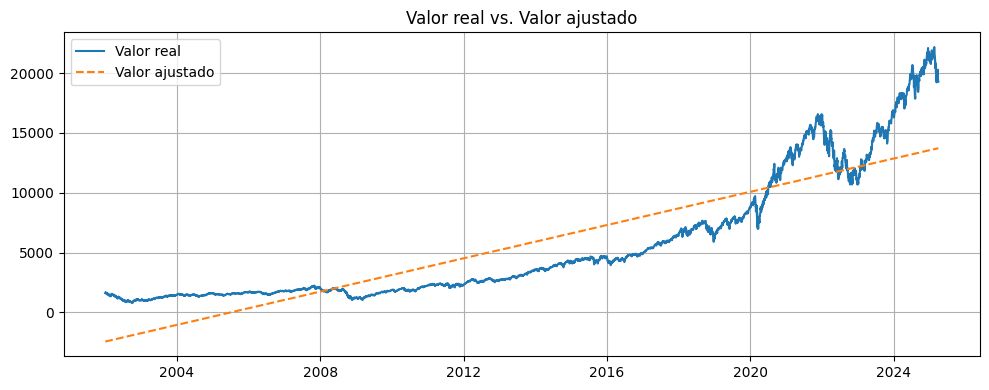

In [48]:
# Supuesto de linealidad #
plt.figure(figsize=(10, 4))
plt.plot(data['^NDX'], label='Valor real')
plt.plot(data['ajustado'], label='Valor ajustado', linestyle='--')
plt.title('Valor real vs. Valor ajustado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Se revisa ahora el test de Durbin-Watson para validar el supuesto de independencia

In [49]:
# Test de Durbin-Watson #
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuos)
print(f"Durbin-Watson Statistic: {dw_stat}")

Durbin-Watson Statistic: 0.0017089979566860898


Este test dice que si la estadística de Durbin-Watson es más o menos igual a 2, los errores no tienen autocorrelación significativa. SIn embargo, se ve que en este caso, la estadística es cercana a cero, lo que indica que los errores pueden tener autocorrelación significativa.

Luego, se implementará el supuesto de Homocedasticidad (Varianza Constante de los Errores) por medio del Test de Breusch-Pagan:

In [50]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(residuos, X)
print(f"Breusch-Pagan p-value: {bp_test[1]}")

Breusch-Pagan p-value: 3.0753746435868773e-186


Este test indica que si el p-value es mayor a 0.05, los errores tienen varianza constante. Pero se observa que son cercanos a cero, por lo que se rechaza la hipótesis nula de que los errores tienen varianza constante.

Por último, se probará el test de Normalidad de los Errores por medio de un histograma y el Test de Shapiro-Wilk:

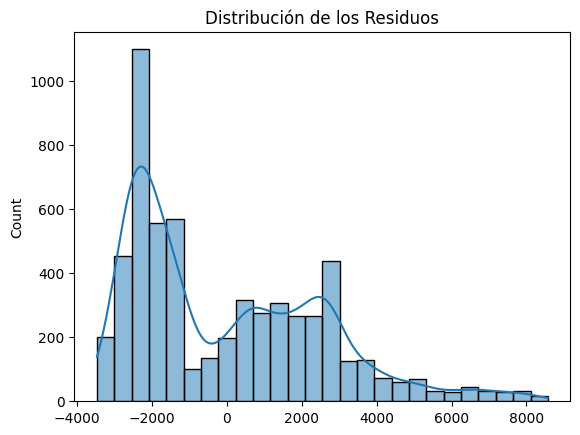

Shapiro-Wilk p-value: 3.9111500517359985e-51


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5849.
  res = hypotest_fun_out(*samples, **kwds)


In [51]:
sns.histplot(residuos, kde=True)
plt.title("Distribución de los Residuos")
plt.show()

shapiro_test = stats.shapiro(residuos)
print(f"Shapiro-Wilk p-value: {shapiro_test[1]}")

Este test indica que si el p-value es mayor a 0.05, los residuos siguen una distribución normal, lo cual en este caso tampoco sucede y por ende, los errores no siguen una distribución normal.

Al no cumplir los supuestos de normalidad la variable ^NDX en función del tiempo, se concluye que no sería correcto ajustar un modelo de regresión lineal en este caso. Es por esto que se procederá a hacer una transformación que permita hacer el modelo en cuestión.

Para ello se transformará la serie.

In [52]:
from scipy.stats import boxcox
ndx_positive = data.drop(columns=["QQQ", "MSFT", "AAPL",	"^SOX",	"^TNX",	"DX-Y.NYB",	"^VXN",	"AMZN"])
df_boxcox = ndx_positive.loc[ndx_positive.index].copy()

# Transformación Box-Cox #
df_boxcox['NDX_boxcox'], fitted_lambda = boxcox(df_boxcox['^NDX'])

# Modelo con Box-Cox
X_box = df_boxcox[['Tiempo']]
y_box = df_boxcox['NDX_boxcox']

model_box = LinearRegression()
model_box.fit(X_box, y_box)
df_boxcox['pred_box'] = model_box.predict(X_box)
df_boxcox['resid_box'] = y_box - df_boxcox['pred_box']

Durbin-Watson Statistic: 0.008512259703999433
Breusch-Pagan p-value: 1.7071798822066663e-99


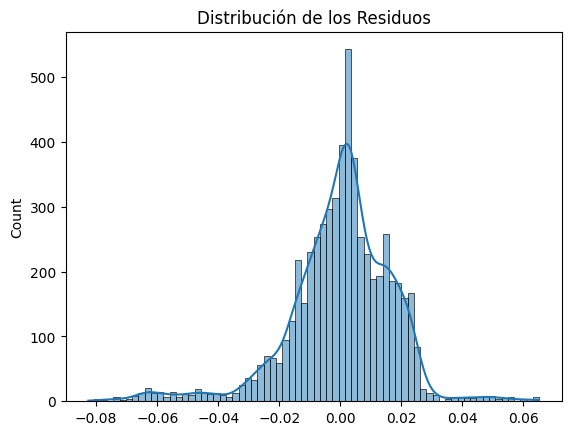

Shapiro-Wilk p-value: 2.5577977753265574e-44


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5849.
  res = hypotest_fun_out(*samples, **kwds)


In [53]:
# Se vuelve a probar los supuestos de normalidad en los residuos #
# Se ajusta el modelo preliminar #
X2 = sm.add_constant(df_boxcox["Tiempo"])
modelo_temp2 = sm.OLS(df_boxcox["NDX_boxcox"], X2).fit()
residuos2 = modelo_temp2.resid

# Test de Durbin-Watson #
dw_stat2 = durbin_watson(residuos2)
print(f"Durbin-Watson Statistic: {dw_stat2}")

# Test de Breusch-Pagan #
bp_test2 = het_breuschpagan(residuos2, X2)
print(f"Breusch-Pagan p-value: {bp_test2[1]}")

# Distribución de los residuos #
sns.histplot(residuos2, kde=True)
plt.title("Distribución de los Residuos")
plt.show()

# Test de Shapiro Wilk #
shapiro_test2 = stats.shapiro(residuos2)
print(f"Shapiro-Wilk p-value: {shapiro_test2[1]}")

Al hacer la transformación de Box-Cox se encontró que de esta manera, los datos tampoco cumplen con los supuestos de normalidad, lo que indica que no sería conveniente ajustar un modelo de regresión lineal.

Sin embargo, por practicidad del ejercicio y por dejar ejemplificado, se procederá a establecer un modelo suponiendo que si se cumplen los supuestos de normalidad.

En primer lugar, se dividirá el conjunto de entrenamiento y prueba para el modelo:

In [54]:
# Se prepara la serie del Nasdaq #
serie_ndx = df_close['^NDX'].dropna().asfreq('B').ffill()

# Se crea una variable lag de 1 día #
df_lr = pd.DataFrame()
df_lr['t'] = serie_ndx
df_lr['t-1'] = serie_ndx.shift(1)
df_lr = df_lr.dropna() # Se eliminan valores nulos generados por el lag

# Se dividen en conjunto de entrenamiento y prueba #
n = len(df_lr)
n_train = int(n * 0.8) # 80% en entrenamiento

df_train = df_lr.iloc[:n_train]
df_test = df_lr.iloc[n_train:]

# División de conjuntos #
# Entrenamiento #
X_train = df_train['t-1']
y_train = df_train['t']

# Prueba #
X_test = df_test['t-1']
y_test = df_test['t']

In [55]:
# Se realiza el ajuste del modelo #
X_train_const = sm.add_constant(X_train)  # Se agrega el intercepto (constante)
modelo_rl = sm.OLS(y_train, X_train_const).fit()

# Summary del modelo #
print(modelo_rl.summary())

                            OLS Regression Results                            
Dep. Variable:                      t   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.970e+06
Date:                Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                        12:51:01   Log-Likelihood:                -26335.
No. Observations:                4850   AIC:                         5.267e+04
Df Residuals:                    4848   BIC:                         5.269e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0138      1.405     -0.722      0.4

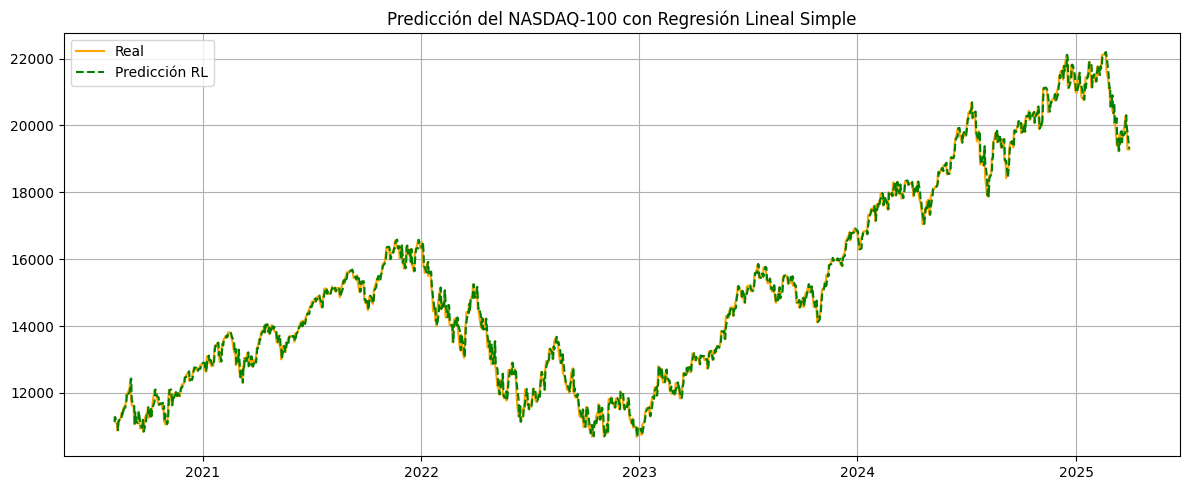

In [56]:
# Se hace predicción según el modelo ajustado
X_test_const = sm.add_constant(X_test)
pred_rl = modelo_rl.predict(X_test_const)

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
# plt.plot(X_train.index, X_train.values, label='Histórico', color='black')
plt.plot(y_test.index, y_test.values, label='Real', color='orange')
plt.plot(y_test.index, pred_rl.values, label='Predicción RL', linestyle="dashed", color='green')
plt.title('Predicción del NASDAQ-100 con Regresión Lineal Simple')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
# Evaluación del modelo #
print(f"Evaluación del modelo de Regresión Lineal en función del Tiempo:")

# RMSE #
rmse_rl = np.sqrt(mean_squared_error(y_test, pred_rl))
print(f"RMSE: {rmse_rl:.4f}")

# MAE #
mae_rl = mean_absolute_error(y_test, pred_rl)
print(f"MAE: {mae_rl:.4f}")

# R^2 #
r2_rl = r2_score(y_test, pred_rl)
print(f"R^2: {r2_rl:.4f}")

# AIC y BIC solo si el modelo los tiene #
aic = modelo_rl.aic
print(f"AIC:  {aic:.2f}")
bic = modelo_rl.bic
print(f"BIC:  {bic:.2f}")

# Se guardan los resultados #
resultados_reg_lineal = {
    "modelo": "Regresión Lineal simple",
    "rmse": rmse_rl,
    "mae": mae_rl,
    "r2": r2_rl,
    "aic": modelo_rl.aic,
    "bic": modelo_rl.bic
}

Evaluación del modelo de Regresión Lineal en función del Tiempo:
RMSE: 205.3791
MAE: 152.4960
R^2: 0.9955
AIC:  52673.49
BIC:  52686.46


#### 4.2.2. Modelo de Regresión Lineal Múltiple

Como se observó anteriormente, no sería correcto ajusta un modelo de la variable NDX en función del tiempo ya que no se cumplen los supuestos de normalidad. Ahora, se ajustará un modelo de Regresión Lineal Múltiple con el fin de ver si el comportamiento del NASDAQ-100 (^NDX) puede explicarse con ayuda de otras variables bursátiles.

##### * Validación de supuestos *

In [59]:
df_mult = df_close[['^NDX', "QQQ", "MSFT", "AAPL",	"^SOX",	"^TNX",	"DX-Y.NYB",	"^VXN",	"AMZN"]].dropna()
df_mult = df_mult.rename(columns={'^NDX': 'Y'})  # variable objetivo

X = df_mult.drop(columns='Y')
X = sm.add_constant(X)  # agregar constante
y = df_mult['Y']

# Ajuste del modelo de regresión múltiple #
modelo = sm.OLS(y, X).fit()
df_mult['residuos'] = modelo.resid
df_mult['ajustados'] = modelo.fittedvalues

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.740e+07
Date:                Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:27:06   Log-Likelihood:                -29008.
No. Observations:                5849   AIC:                         5.803e+04
Df Residuals:                    5840   BIC:                         5.809e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        371.7689      5.045     73.694      0.0

En primer lugar se hará la validación de supuestos, empezando por Relación Lineal entre la Variable Dependiente y las Predictoras

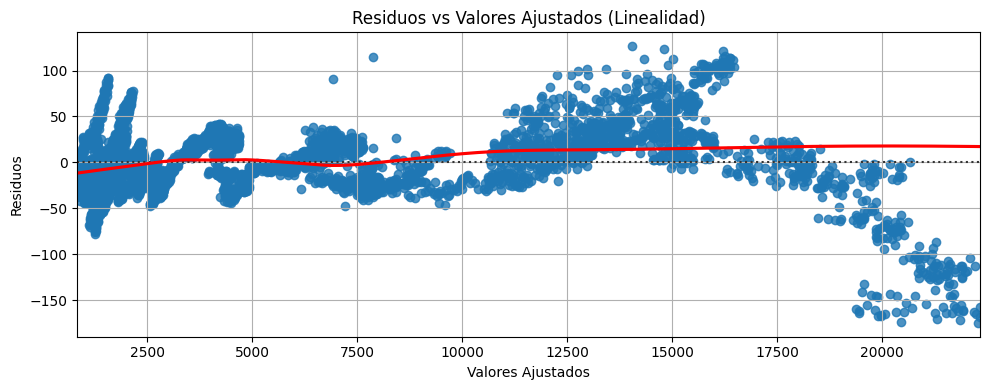

In [60]:
## Linealidad: residuos vs valores ajustados #
plt.figure(figsize=(10, 4))
sns.residplot(x=df_mult['ajustados'], y=df_mult['residuos'], lowess=True, line_kws={'color': 'red'})
plt.title('Residuos vs Valores Ajustados (Linealidad)')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.grid(True)
plt.tight_layout()
plt.show()

Se observa que los residuos no son lineales con respecto a los valores ajustados, de manera que no se cunmple el supuesto de linealidad.

Ahora, se revisará la independencia de los Errores. Para ello se hará uso del test de Durbin-Watson:

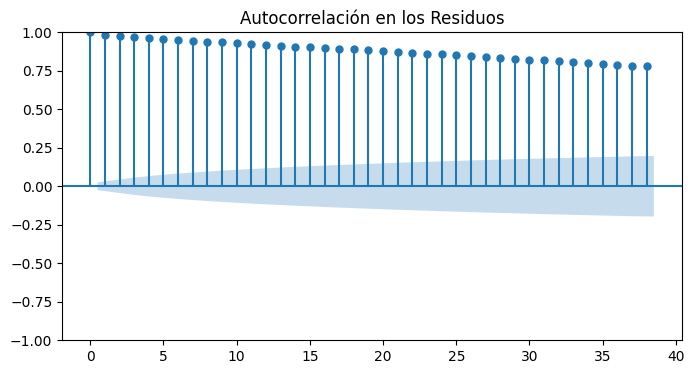


Durbin-Watson Statistic: 0.0325 (valor cercano a 2 indica independencia)


In [62]:
# Ajustar modelo preliminar para obtener residuos #
modelo_temp = sm.OLS(df_close["^NDX"], sm.add_constant(df_close.drop(columns=["^NDX"]))).fit()
residuos = modelo_temp.resid

# Se grafica el ACF de los residuos #
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_acf(residuos, ax=ax)
plt.title("Autocorrelación en los Residuos")
plt.show()

# Test de Durbin-Watson #
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(df_mult['residuos'])
print(f"\nDurbin-Watson Statistic: {dw_stat:.4f} (valor cercano a 2 indica independencia)")

Este test dice que si la estadística de Durbin-Watson es más o menos igual a 2, los errores no tienen autocorrelación significativa. SIn embargo, se ve que en este caso, la estadística es cercana a cero, lo que indica que los errores pueden tener autocorrelación significativa, además de que el ACF muestra una alta correlación.

Luego, se implementará el supuesto de Homocedasticidad (Varianza Constante de los Errores) por medio del Test de Breusch-Pagan:

In [63]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Aplicar la prueba de Breusch-Pagan #
bp_test = het_breuschpagan(df_mult['residuos'], X)
labels = ['LM stat', 'p-value', 'F-stat', 'F p-value']
print("\nBreusch-Pagan Test:")
for name, val in zip(labels, bp_test):
    print(f"{name}: {val:.4f}")


Breusch-Pagan Test:
LM stat: 2067.0598
p-value: 0.0000
F-stat: 398.9893
F p-value: 0.0000


Este test indica que si el p-value es mayor a 0.05, los errores tienen varianza constante. Pero se observa que son iguales a cero, por lo que se rechaza la hipótesis nula de que los errores tienen varianza constante.

Luego, se prueba el test de Normalidad de los Errores por medio de gráficos y los Test de Shapiro-Wilk y Jarque-Bera:

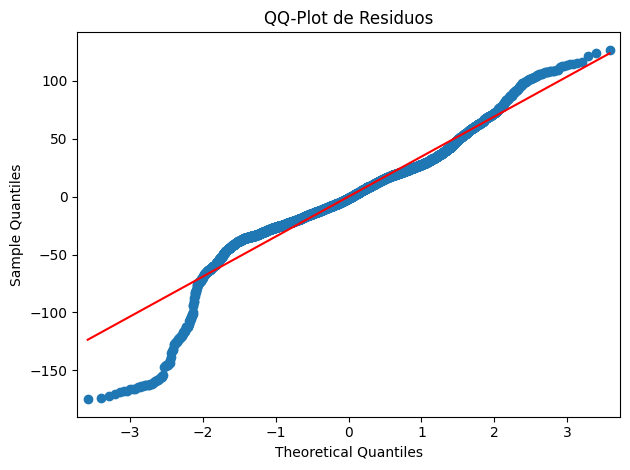

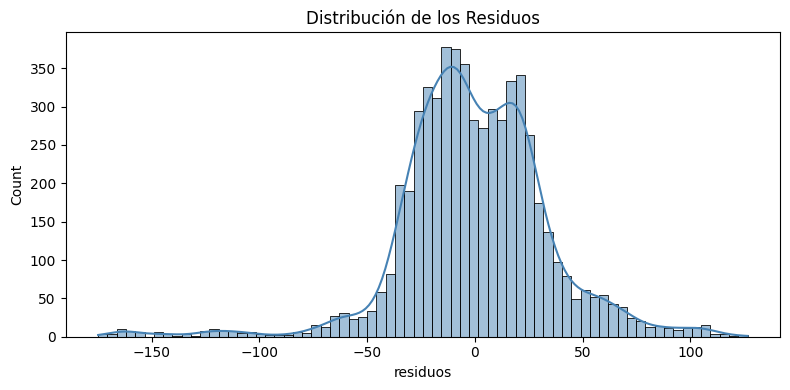


Shapiro-Wilk Test: Statistic=0.9409, p-value=0.0000
Jarque-Bera Test: Statistic=3937.3062, p-value=0.0000


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5849.
  res = hypotest_fun_out(*samples, **kwds)


In [65]:
# Grafico QQ Plot residuos #
from statsmodels.graphics.gofplots import qqplot
qqplot(df_mult['residuos'], line='s')
plt.title('QQ-Plot de Residuos')
plt.tight_layout()
plt.show()

# Graficar distribución de los residuos #
plt.figure(figsize=(8, 4))
sns.histplot(df_mult['residuos'], kde=True, color='steelblue')
plt.title('Distribución de los Residuos')
plt.tight_layout()
plt.show()

# Test de Shapiro-Wilk y Jarque-Bera #
shapiro_stat, shapiro_p = shapiro(df_mult['residuos'])
jb_stat, jb_p = jarque_bera(df_mult['residuos'])

print(f"\nShapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
print(f"Jarque-Bera Test: Statistic={jb_stat:.4f}, p-value={jb_p:.4f}")

Estos tests indican que si el p-value es mayor a 0.05, los residuos siguen una distribución normal, lo cual en este caso tampoco sucede y por ende, los errores no siguen una distribución normal.

Por último, se validará el supuesto de No Multicolinealidad Entre las Variables Predictoras, para el cual se usará el VIF (Factor de Inflación de la Varianza):

In [66]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcular VIF #
vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVIF (Factor de Inflación de la Varianza):")
print(vif_df)


VIF (Factor de Inflación de la Varianza):
   Variable         VIF
0     const  124.970041
1       QQQ  330.294964
2      MSFT  137.482571
3      AAPL   84.714748
4      ^SOX  132.258974
5      ^TNX    2.895132
6  DX-Y.NYB    1.946361
7      ^VXN    1.996622
8      AMZN   44.125930


Este test indica que si el valor de VIF es menor a 5 para todas las variables, no hay multicolinealidad severa y podemos proceder con la regresión, pero en este caso no sucede de esta manera.

Partiendo de esto, se concluye que un modelo de regresión lineal múltiple no seria el adecuado al igual que el inciso anterior. Sin embargo, por practicidad del ejercicio y por dejar ejemplificado, se procederá a establecer un modelo suponiendo que si se cumplen los supuestos de normalidad.

In [67]:
# En primer lugar se hace la selección del objetivo y variables exógenas #
variables = ["QQQ", "MSFT", "AAPL",	"^SOX",	"^TNX",	"DX-Y.NYB",	"^VXN",	"AMZN"]
df_regresion = df_close[['^NDX'] + variables].dropna().asfreq('B').ffill()

# Luego, se hace la división en conjunto de entrenamiento y prueba #
n = len(df_regresion)
n_train = int(n * 0.8)

df_train = df_regresion.iloc[:n_train]
df_test = df_regresion.iloc[n_train:]

X_train = df_train[variables]
y_train = df_train['^NDX']
X_test = df_test[variables]
y_test = df_test['^NDX']

In [68]:
# Ajuste del modelo múltiple #
X_train_const = sm.add_constant(X_train)  # Intercepto
modelo_rlm = sm.OLS(y_train, X_train_const).fit()

# Summary del modelo #
print(modelo_rlm.summary())

                            OLS Regression Results                            
Dep. Variable:                   ^NDX   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.506e+07
Date:                Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                        14:15:05   Log-Likelihood:                -19751.
No. Observations:                4851   AIC:                         3.952e+04
Df Residuals:                    4842   BIC:                         3.958e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        229.4695      2.645     86.750      0.0

Al tener todas las variables un valor p < 0.05, se dice que todas las variables escogidas (activos bursátiles), son significativas para el modelado del comportamiento del Nasdaq-100.

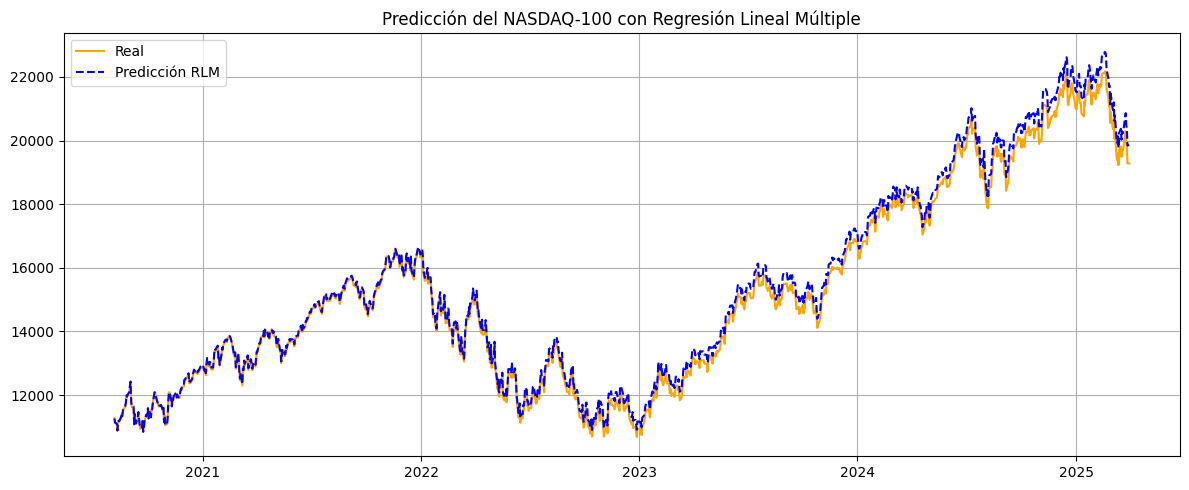

In [69]:
# Predicciones según el modelo #
X_test_const = sm.add_constant(X_test)
pred_rlm = modelo_rlm.predict(X_test_const)

# Visualización de predicciones #
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.values, label='Real', color='orange')
plt.plot(y_test.index, pred_rlm.values, label='Predicción RLM', linestyle = "dashed", color='blue')
plt.title('Predicción del NASDAQ-100 con Regresión Lineal Múltiple')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
# Evaluación del modelo #
print(f"Evaluación del modelo de Regresión Lineal Múltiple:")

# RMSE #
rmse_rlm = np.sqrt(mean_squared_error(y_test, pred_rlm))
print(f"RMSE: {rmse_rlm:.4f}")

# MAE #
mae_rlm = mean_absolute_error(y_test, pred_rlm)
print(f"MAE: {mae_rlm:.4f}")

# R^2 #
r2_rlm = r2_score(y_test, pred_rlm)
print(f"R^2: {r2_rlm:.4f}")

# AIC y BIC solo si el modelo los tiene #
aic = modelo_rlm.aic
print(f"AIC:  {aic:.2f}")
bic = modelo_rlm.bic
print(f"BIC:  {bic:.2f}")

# Se guardan los resultados #
resultados_rl_multi = {
    "modelo": "Regresión Lineal Múltiple",
    "rmse": rmse_rlm,
    "mae": mae_rlm,
    "r2": r2_rlm,
    "aic": modelo_rlm.aic,
    "bic": modelo_rlm.bic
}

Evaluación del modelo de Regresión Lineal Múltiple:
RMSE: 265.5317
MAE: 214.8113
R^2: 0.9924
AIC:  39519.99
BIC:  39578.38


#### 4.2.3. Modelo de Random Forest Regressor

Ahora, se ajustará un modelo de Random Forest Regressor, el cual puede funcionar muy bien con conjuntos de datos financieros donde las relaciones entre variables pueden ser complejas, no lineales y con mucha interacción.

In [71]:
# En primer lugar se hace la selección del objetivo y variables exógenas #
# Se utiliza el listado de variables definidas anteriormente #
df_rf = df_close[['^NDX'] + variables].dropna().asfreq('B').ffill()

# Luego, se hace la división en conjunto de entrenamiento y prueba #
n = len(df_rf)
n_train = int(n * 0.8)

df_train = df_rf.iloc[:n_train]
df_test = df_rf.iloc[n_train:]

X_train = df_train[variables]
y_train = df_train['^NDX']
X_test = df_test[variables]
y_test = df_test['^NDX']

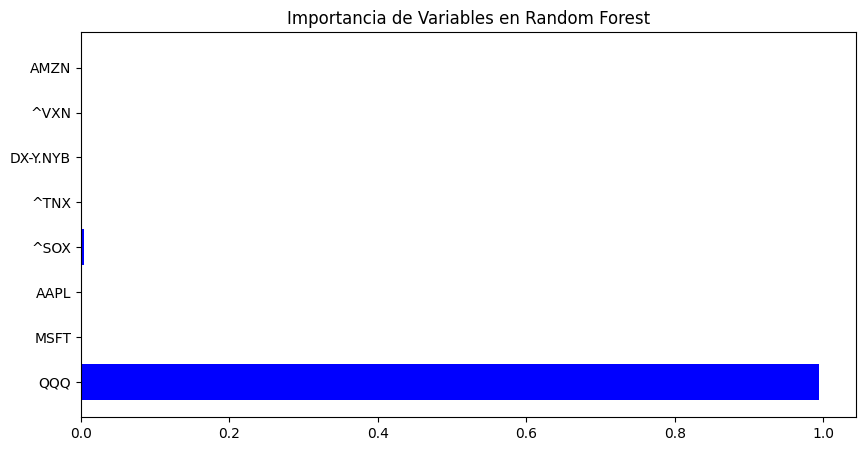

In [74]:
# Entrenar modelo preliminar para evaluar importancia de variables #
modelo_rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf_temp.fit(X_train, y_train)

# Graficar importancia de características
importances = modelo_rf_temp.feature_importances_
features = df_close[variables].columns

plt.figure(figsize=(10,5))
plt.barh(features, importances, color="blue")
plt.title("Importancia de Variables en Random Forest")
plt.show()

In [75]:
from sklearn.model_selection import GridSearchCV
# Se define el modelo base #
modelo_rf = RandomForestRegressor(random_state=42)

# Definir búsqueda de hiperparámetros #
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 4]
}

# Búsqueda de mejores hiperparámetros #
grid_search = GridSearchCV(modelo_rf, param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor configuración encontrada #
print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [76]:
# Entrenar el modelo con los mejores parámetros encontrados #
modelo_rf_final = RandomForestRegressor(**grid_search.best_params_, random_state=42)
modelo_rf_final.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

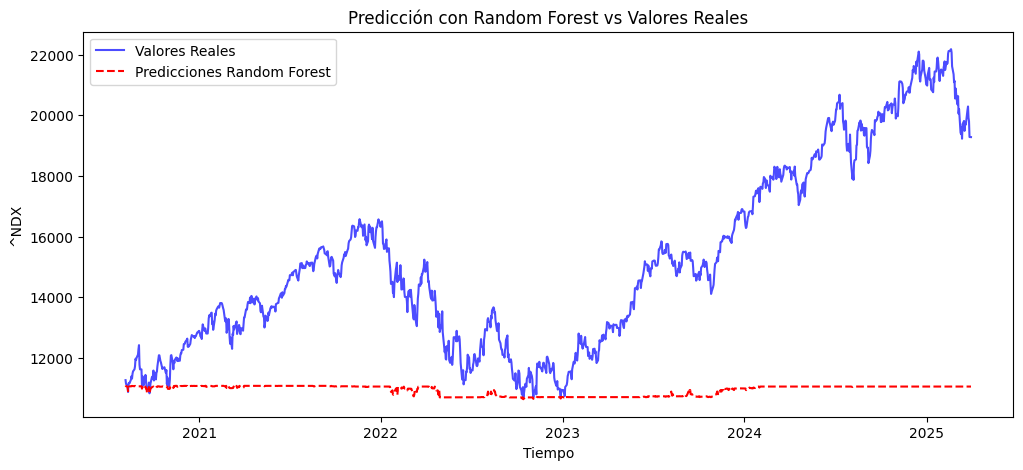

In [78]:
# Predicción sobre el conjunto de prueba #
y_pred = modelo_rf_final.predict(X_test)

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label="Valores Reales", color="blue", alpha=0.7)
plt.plot(y_test.index, y_pred, linestyle="dashed", color="red", label="Predicciones Random Forest")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("^NDX")
plt.title("Predicción con Random Forest vs Valores Reales")
plt.show()

In [79]:
# Evaluación del modelo #
print(f"Evaluación del modelo de Random Forest Regressor:")

# RMSE #
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
print(f"RMSE: {rmse_rf:.4f}")

# MAE #
mae_rf = mean_absolute_error(y_test, pred_rf)
print(f"MAE: {mae_rf:.4f}")

# R^2 #
r2_rf = r2_score(y_test, pred_rf)
print(f"R^2: {r2_rf:.4f}")

# AIC y BIC no tiene #

# Se guardan los resultados #
resultados_rf = {
    "modelo": "Random Forest",
    "rmse": rmse_rf,
    "mae": mae_rf,
    "r2": r2_rf,
    "aic": None,
    "bic": None
}

Evaluación del modelo de Random Forest Regressor:
RMSE: 5151.7177
MAE: 4211.7868
R^2: -1.8607


<ipython-input-80-de17cce7b265>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importancias, x='Importancia', y='Variable', palette='viridis')


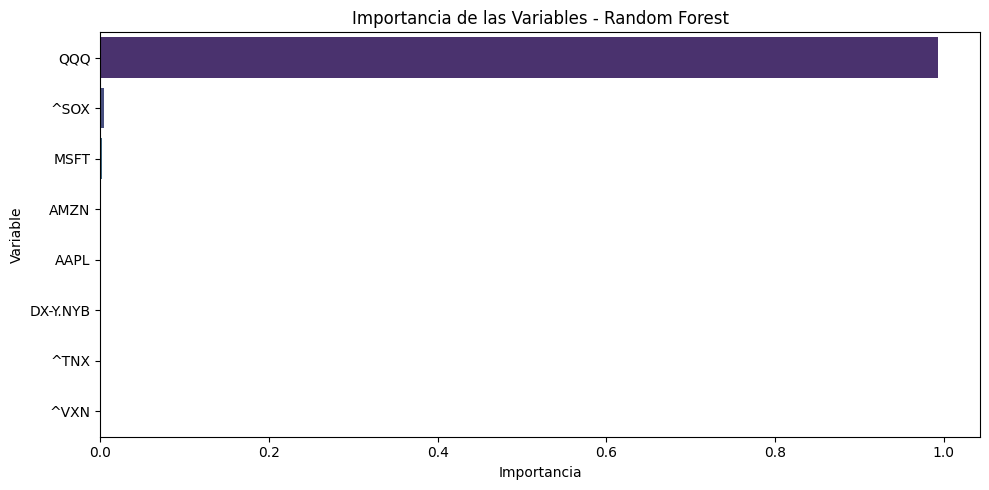

In [80]:
# Se revisa la importancia de variables #
importancias = modelo_rf_final.feature_importances_
variables = X_train.columns

df_importancias = pd.DataFrame({
    'Variable': variables,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# Visualización de las importancias #
plt.figure(figsize=(10, 5))
sns.barplot(data=df_importancias, x='Importancia', y='Variable', palette='viridis')
plt.title('Importancia de las Variables - Random Forest')
plt.tight_layout()
plt.show()

Inicialmente, se observa que solamente 1 activo es de gran importancia para el modelado de la serie del Nasdaq-100 "QQQ".

Sin embargo, se observa que se predice bien al inicio pero luego se vuelve una linea constante. Esto se puede deber a que Random Forest no tiene "memoria" ni conciencia del tiempo, de manera que si no se incluyen explícitamente variables de fecha, lags o alguna estructura de tiempo, el modelo no puede entender la secuencia temporal.

#### 4.2.4. Modelo XGBoost

Este modelo suele tener un rendimiento superior para series temporales cuando se usan lags y/o características adicionales

In [86]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Se preparan los datos #
df_model = df_close[['^NDX', "QQQ","MSFT","AAPL","^SOX","^TNX","DX-Y.NYB","^VXN","AMZN"]].dropna()
df_model = df_model.rename(columns={'^NDX': 'target'})

X = df_model.drop(columns='target')
y = df_model['target']

# Se escalan los datos #
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División en conjunto de entrenamiento y prueba #
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

In [90]:
# Se define el modelo base y parámetros para búsqueda #
from xgboost import XGBRegressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='neg_root_mean_squared_error',
                           cv=3,
                           verbose=1,
                           n_jobs=-1)

In [91]:
# Se entrena el modelo con la búsqueda de hiperparámetros #
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=1)


🏆 Mejores hiperparámetros encontrados:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


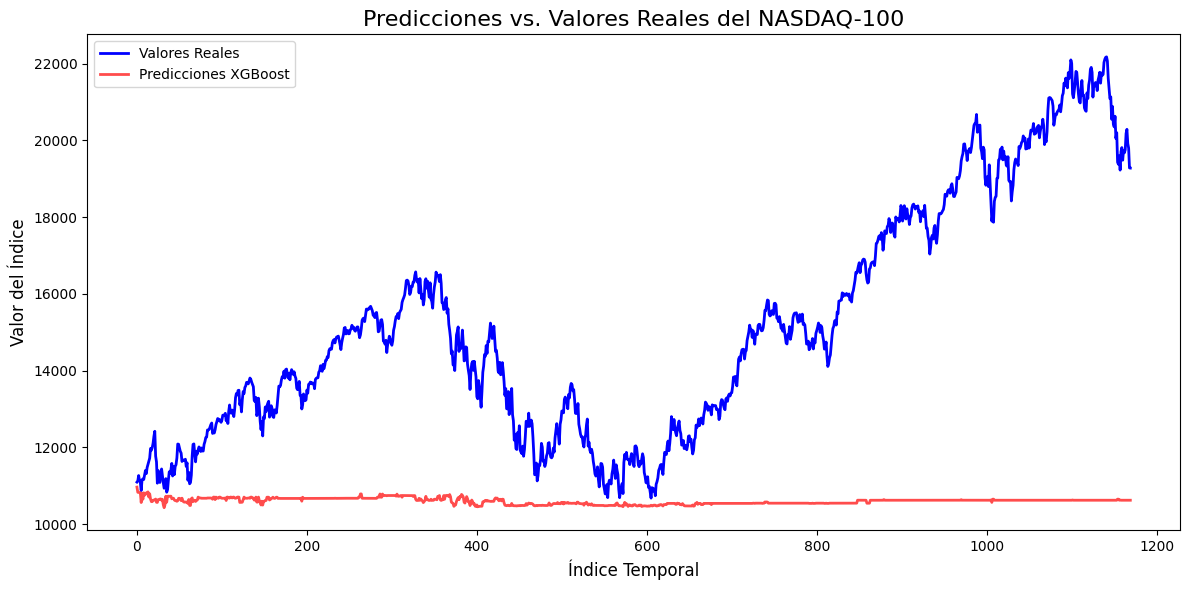

In [94]:
# Predicciones con el ajuste del modelo #
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n🏆 Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Visualización de las predicciones #
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Valores Reales', color='blue', linewidth=2)
plt.plot(y_pred, label='Predicciones XGBoost', color='red', linewidth=2, alpha=0.7)
plt.title('Predicciones vs. Valores Reales del NASDAQ-100', fontsize=16)
plt.xlabel('Índice Temporal', fontsize=12)
plt.ylabel('Valor del Índice', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [95]:
# Evaluación del modelo #
print(f"Evaluación del modelo de XGBoost:")

# RMSE #
rmse_xgb = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse_xgb:.4f}")

# MAE #
mae_xgb = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae_xgb:.4f}")

# R^2 #
r2_xgb = r2_score(y_test, y_pred)
print(f"R^2: {r2_xgb:.4f}")

# AIC y BIC no tiene en XGBoost #

# Se guardan los resultados #
resultados_xgb = {
    "modelo": "XGBoost",
    "rmse": rmse_xgb,
    "mae": mae_xgb,
    "r2": r2_xgb,
    "aic": None,
    "bic": None
}

Evaluación del modelo de XGBoost:
RMSE: 5438.7294
MAE: 4527.3707
R^2: -2.2109


<ipython-input-97-9dd0a2c98569>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importancias[indices], y=nombres_variables[indices], palette='viridis')


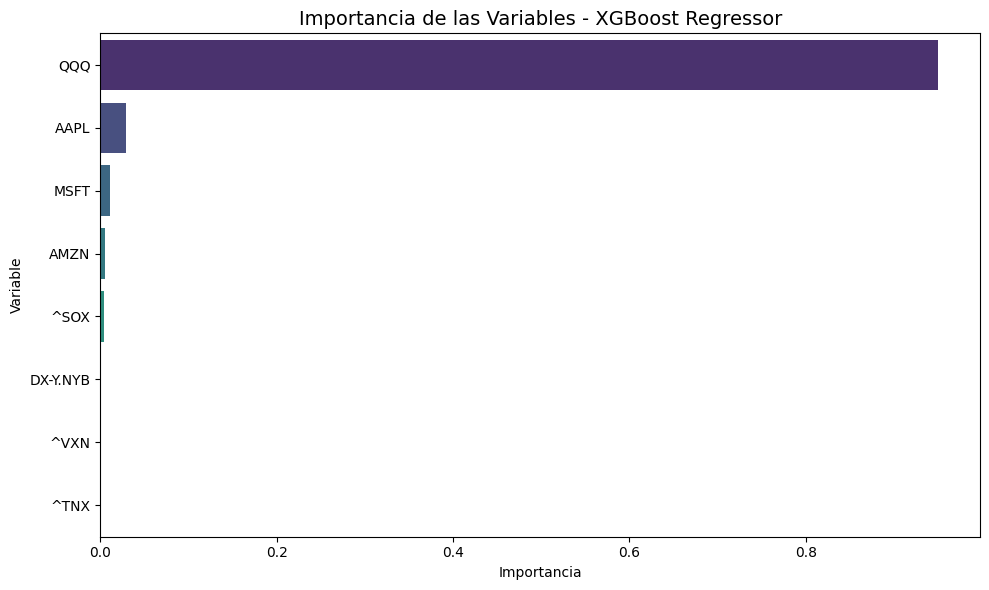

In [97]:
# Visualización de la importancia de variables por "gain" #
# Obtener importancia de las características #
importancias = best_model.feature_importances_
nombres_variables = X.columns  # usa los nombres originales antes de escalar
indices = np.argsort(importancias)[::-1]

# Crear gráfico #
plt.figure(figsize=(10, 6))
sns.barplot(x=importancias[indices], y=nombres_variables[indices], palette='viridis')
plt.title('Importancia de las Variables - XGBoost Regressor', fontsize=14)
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

#### 4.2.5. Modelo LSTM

Los modelos LSTM (Long Short-Term Memory), son ideales para predecir series de tiempo financieras como el NASDAQ-100, ya que pueden capturar dependencias a largo plazo y manejar secuencias con memoria.

In [98]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import GRU, Dense

In [103]:
# Se selecciona y escala la serie #
serie_ndx = df_close['^NDX'].dropna().values.reshape(-1, 1)

scaler = MinMaxScaler()
serie_scaled = scaler.fit_transform(serie_ndx)

# Convertir a formato supervisado #
def crear_secuencias(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

n_steps = 10  # Se crea una ventana de 10 días
X, y = crear_secuencias(serie_scaled, n_steps)

# Reshape para LSTM [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Dividir en train y test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [104]:
# Construcción del modelo LSTM #
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dense(1)) # Salida
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo #
history = model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
146/146 [==============================] - 11s 24ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 2/100
146/146 [==============================] - 3s 20ms/step - loss: 2.8170e-05 - val_loss: 4.4486e-04
Epoch 3/100
146/146 [==============================] - 2s 11ms/step - loss: 2.5057e-05 - val_loss: 4.4273e-04
Epoch 4/100
146/146 [==============================] - 1s 8ms/step - loss: 2.2473e-05 - val_loss: 4.4582e-04
Epoch 5/100
146/146 [==============================] - 1s 8ms/step - loss: 2.4964e-05 - val_loss: 7.4681e-04
Epoch 6/100
146/146 [==============================] - 1s 8ms/step - loss: 2.4792e-05 - val_loss: 5.0533e-04
Epoch 7/100
146/146 [==============================] - 1s 8ms/step - loss: 2.3684e-05 - val_loss: 5.8936e-04
Epoch 8/100
146/146 [==============================] - 1s 8ms/step - loss: 2.4429e-05 - val_loss: 5.7793e-04
Epoch 9/100
146/146 [==============================] - 1s 8ms/step - loss: 2.2443e-05 - val_loss: 5.6400e-04
Epoch 10/100
146/146 [=

37/37 [==============================] - 1s 3ms/step


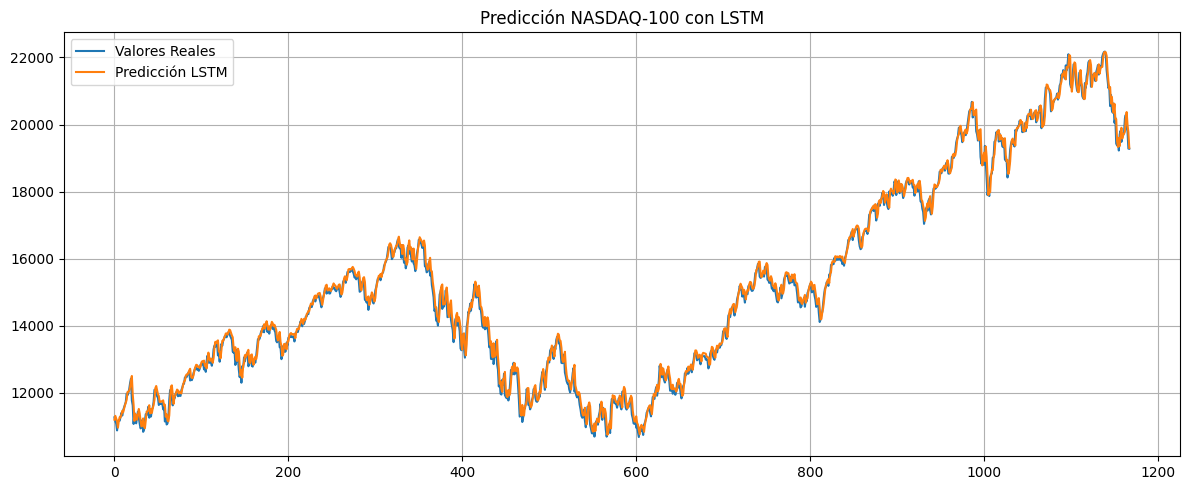

In [105]:
# Predicciones con el ajuste del modelo #
y_pred_scaled = model_lstm.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_real = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualización de predicciones #
plt.figure(figsize=(12, 5))
plt.plot(y_real, label='Valores Reales')
plt.plot(y_pred, label='Predicción LSTM')
plt.title('Predicción NASDAQ-100 con LSTM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [106]:
# Evaluación del modelo #
print(f"Evaluación del modelo de LSTM:")

# RMSE #
rmse_lstm = mean_squared_error(y_real, y_pred, squared=False)
print(f"RMSE: {rmse_lstm:.4f}")

# MAE #
mae_lstm = mean_absolute_error(y_real, y_pred)
print(f"MAE: {mae_lstm:.4f}")

# R^2 #
r2_lstm = r2_score(y_real, y_pred)
print(f"R^2: {r2_lstm:.4f}")

# AIC y BIC no tiene en XGBoost #

# Se guardan los resultados #
resultados_lstm = {
    "modelo": "LSTM",
    "rmse": rmse_lstm,
    "mae": mae_lstm,
    "r2": r2_lstm,
    "aic": None,
    "bic": None
}

Evaluación del modelo de LSTM:
RMSE: 220.0642
MAE: 167.2956
R^2: 0.9947


#### 4.2.6. Modelo LSTM Multivariado

Un modelo LSTM multivariado es ideal cuando se quiere predecir una variable objetivo (como el precio del NASDAQ-100) teniendo en cuenta varias series de tiempo como entradas, lo cual refleja mucho mejor la realidad de los mercados financieros.

In [110]:
# Variables a utilizar #
variables = ["^NDX","QQQ","MSFT","AAPL","^SOX","^TNX","DX-Y.NYB","^VXN","AMZN"]
df_multi = df_close[variables].dropna().asfreq('B').ffill()

# Se escalan todas las series #
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_multi), columns=variables, index=df_multi.index)

# Se crean secuencias multivariadas #
def crear_secuencias_multivariadas(data, target_col='^NDX', ventana=60):
    X, y = [], []
    for i in range(ventana, len(data)):
        X.append(data.iloc[i-ventana:i].values)
        y.append(data.iloc[i][target_col])
    return np.array(X), np.array(y)

ventana = 10
X_mv, y_mv = crear_secuencias_multivariadas(df_scaled, ventana=ventana)

In [111]:
# División del conjunto en entrenamiento y prueba #
n = len(X_mv)
n_train = int(n * 0.8)

X_train_mv = X_mv[:n_train]
X_test_mv = X_mv[n_train:]
y_train_mv = y_mv[:n_train]
y_test_mv = y_mv[n_train:]

In [112]:
# Modelo LSTM multivariado #
model_mv = Sequential()
model_mv.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_mv.shape[1], X_train_mv.shape[2])))
model_mv.add(Dense(1))

model_mv.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo #
history_mv = model_mv.fit(X_train_mv, y_train_mv, epochs=100, batch_size=32, validation_data=(X_test_mv, y_test_mv), verbose=1)

Epoch 1/100
152/152 [==============================] - 10s 20ms/step - loss: 0.0026 - val_loss: 0.0075
Epoch 2/100
152/152 [==============================] - 1s 8ms/step - loss: 9.3494e-05 - val_loss: 0.0086
Epoch 3/100
152/152 [==============================] - 2s 12ms/step - loss: 6.2537e-05 - val_loss: 0.0089
Epoch 4/100
152/152 [==============================] - 2s 11ms/step - loss: 4.4731e-05 - val_loss: 0.0086
Epoch 5/100
152/152 [==============================] - 1s 8ms/step - loss: 3.2077e-05 - val_loss: 0.0080
Epoch 6/100
152/152 [==============================] - 1s 8ms/step - loss: 2.4559e-05 - val_loss: 0.0087
Epoch 7/100
152/152 [==============================] - 1s 8ms/step - loss: 1.9935e-05 - val_loss: 0.0074
Epoch 8/100
152/152 [==============================] - 1s 8ms/step - loss: 1.8937e-05 - val_loss: 0.0074
Epoch 9/100
152/152 [==============================] - 1s 8ms/step - loss: 1.5634e-05 - val_loss: 0.0067
Epoch 10/100
152/152 [==============================] -

38/38 [==============================] - 1s 3ms/step


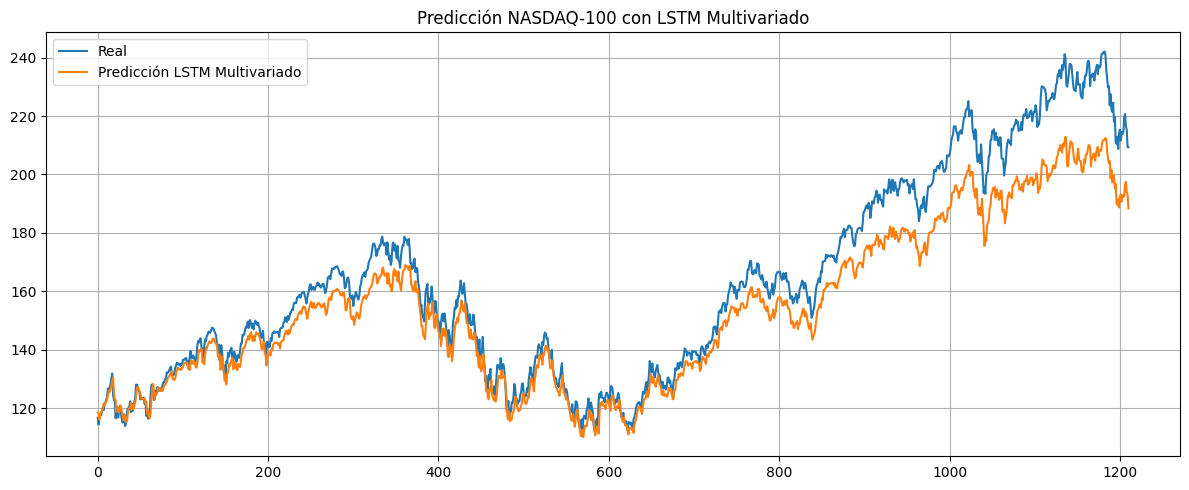

In [113]:
# Predicción del modelo ajustado #
y_pred_mv_scaled = model_mv.predict(X_test_mv)
y_pred_mv = scaler.inverse_transform(
    np.concatenate([
        np.zeros((len(y_pred_mv_scaled), len(variables) - 1)),
        y_pred_mv_scaled
    ], axis=1)
)[:, -1]

y_real_mv = scaler.inverse_transform(
    np.concatenate([
        np.zeros((len(y_test_mv), len(variables) - 1)),
        y_test_mv.reshape(-1, 1)
    ], axis=1)
)[:, -1]

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
plt.plot(y_real_mv, label='Real')
plt.plot(y_pred_mv, label='Predicción LSTM Multivariado')
plt.title('Predicción NASDAQ-100 con LSTM Multivariado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [114]:
# Evaluación del modelo #
print(f"Evaluación del modelo de LSTM Multivariado:")

# RMSE #
rmse_mv = np.sqrt(mean_squared_error(y_real_mv, y_pred_mv))
print(f"RMSE: {rmse_mv:.4f}")

# MAE #
mae_mv = mean_absolute_error(y_real_mv, y_pred_mv)
print(f"MAE: {mae_mv:.4f}")

# R^2 #
r2_mv = r2_score(y_real_mv, y_pred_mv)
print(f"R^2: {r2_mv:.4f}")

# AIC y BIC no tiene en XGBoost #

# Se guardan los resultados #
resultados_lstm_multi = {
    "modelo": "LSTM Multivariado",
    "rmse": rmse_mv,
    "mae": mae_mv,
    "r2": r2_mv,
    "aic": None,
    "bic": None
}

Evaluación del modelo de LSTM Multivariado:
RMSE: 11.9370
MAE: 9.1048
R^2: 0.8797


#### 4.2.7. Modelo GRU Multivariado

Por último, se preparará el modelado completo del GRU multivariado tal como se hizo con LSTM, para mantener la coherencia en la metodología.

In [115]:
# Variables seleccionadas #
variables = ["^NDX","QQQ","MSFT","AAPL","^SOX","^TNX","DX-Y.NYB","^VXN","AMZN"]
df_gru = df_close[variables].dropna().asfreq('B').ffill()

# Se escalan todas las series #
scaler = MinMaxScaler()
df_scaled_gru = pd.DataFrame(scaler.fit_transform(df_gru), columns=variables, index=df_gru.index)

# Se crean secuencias multivariadas #
def crear_secuencias_multivariadas(data, target_col='^NDX', ventana=60):
    X, y = [], []
    for i in range(ventana, len(data)):
        X.append(data.iloc[i-ventana:i].values)
        y.append(data.iloc[i][target_col])
    return np.array(X), np.array(y)

ventana = 10
X_gru, y_gru = crear_secuencias_multivariadas(df_scaled_gru, ventana=ventana)

In [116]:
# Se divide el conjunto en entrenamiento y prueba #
n = len(X_gru)
n_train = int(n * 0.8)

X_train_gru = X_gru[:n_train]
X_test_gru = X_gru[n_train:]
y_train_gru = y_gru[:n_train]
y_test_gru = y_gru[n_train:]

In [117]:
# Construcción y entrenamiento del modelo GRU #
# Se define el modelo GRU #
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=False, input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])))
model_gru.add(Dense(1))

model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo #
history_gru = model_gru.fit(X_train_gru, y_train_gru, epochs=100, batch_size=32, validation_data=(X_test_gru, y_test_gru), verbose=1)

Epoch 1/100
152/152 [==============================] - 8s 15ms/step - loss: 0.0019 - val_loss: 0.0223
Epoch 2/100
152/152 [==============================] - 1s 8ms/step - loss: 1.2145e-04 - val_loss: 0.0135
Epoch 3/100
152/152 [==============================] - 1s 8ms/step - loss: 6.5390e-05 - val_loss: 0.0076
Epoch 4/100
152/152 [==============================] - 1s 8ms/step - loss: 3.3952e-05 - val_loss: 0.0029
Epoch 5/100
152/152 [==============================] - 1s 8ms/step - loss: 1.9476e-05 - val_loss: 0.0015
Epoch 6/100
152/152 [==============================] - 1s 8ms/step - loss: 1.5077e-05 - val_loss: 9.9166e-04
Epoch 7/100
152/152 [==============================] - 1s 8ms/step - loss: 1.2716e-05 - val_loss: 7.2559e-04
Epoch 8/100
152/152 [==============================] - 1s 8ms/step - loss: 1.2128e-05 - val_loss: 6.5586e-04
Epoch 9/100
152/152 [==============================] - 2s 13ms/step - loss: 1.0807e-05 - val_loss: 0.0014
Epoch 10/100
152/152 [=======================

38/38 [==============================] - 1s 3ms/step


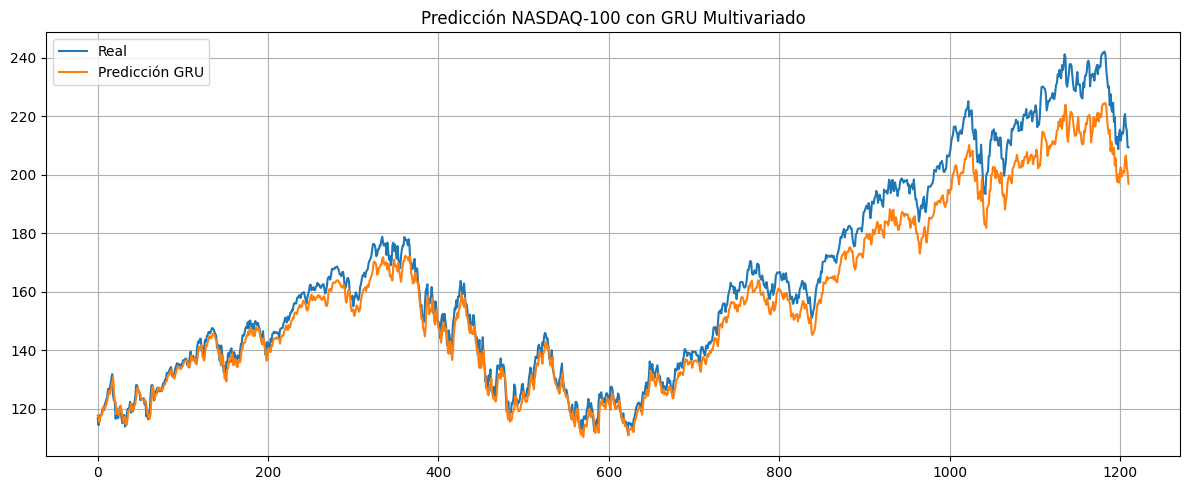

In [118]:
# Se calculan las predicciones del modelo #
y_pred_gru_scaled = model_gru.predict(X_test_gru)

# Inversión del escalado SOLO para la columna target (^NDX) #
y_pred_gru = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_pred_gru_scaled), len(variables)-1)), y_pred_gru_scaled], axis=1)
)[:, -1]

y_real_gru = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_test_gru), len(variables)-1)), y_test_gru.reshape(-1,1)], axis=1)
)[:, -1]

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
plt.plot(y_real_gru, label='Real')
plt.plot(y_pred_gru, label='Predicción GRU')
plt.title('Predicción NASDAQ-100 con GRU Multivariado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [119]:
# Evaluación del modelo #
print(f"Evaluación del modelo GRU Multivariado:")

# RMSE #
rmse_gru = np.sqrt(mean_squared_error(y_real_gru, y_pred_gru))
print(f"RMSE: {rmse_gru:.4f}")

# MAE #
mae_gru = mean_absolute_error(y_real_gru, y_pred_gru)
print(f"MAE: {mae_gru:.4f}")

# R^2 #
r2_gru = r2_score(y_real_gru, y_pred_gru)
print(f"R^2: {r2_gru:.4f}")

# AIC y BIC no tiene en XGBoost #

# Se guardan los resultados #
resultados_gru = {
    "modelo": "GRU Multivariado",
    "rmse": rmse_gru,
    "mae": mae_gru,
    "r2": r2_gru,
    "aic": None,
    "bic": None
}

Evaluación del modelo GRU Multivariado:
RMSE: 8.0570
MAE: 6.2707
R^2: 0.9452


## 5. Comparación de resultados de modelos (Evaluación)

In [120]:
# Se consolidan los resultados en un DataFrame #
resultados_modelos = [resultados_ARIMA, resultados_ARIMAX, resultados_SARIMA, resultados_GARCH,
                      resultados_reg_lineal, resultados_rl_multi, resultados_rf, resultados_xgb,
                      resultados_lstm, resultados_lstm_multi, resultados_gru]
df_resultados = pd.DataFrame(resultados_modelos)
columnas_orden = ['modelo', 'rmse', 'mae', 'r2', 'aic', 'bic']
df_resultados = df_resultados[columnas_orden]

print("Comparación de modelos:")
print(df_resultados)

# Exportar a Excel o CSV (se hará luego) #
# df_resultados.to_csv("comparacion_modelos.csv", index=False)

Comparación de modelos:
                       modelo         rmse          mae        r2  \
0                ARIMA(1,1,1)   208.922249   157.903235 -0.000065   
1               ARIMAX(1,1,1)    11.857210     8.471487  0.996779   
2     SARIMA(1,1,1,12)(1,1,1)   209.016330   157.925548 -0.000966   
3                  GARCH(1,1)   136.216490   107.502921  0.000000   
4     Regresión Lineal simple   205.379107   152.495978  0.995453   
5   Regresión Lineal Múltiple   265.531718   214.811252  0.992400   
6               Random Forest  5151.717700  4211.786807 -1.860740   
7                     XGBoost  5438.729450  4527.370672 -2.210894   
8                        LSTM   220.064191   167.295586  0.994736   
9           LSTM Multivariado    11.936954     9.104760  0.879692   
10           GRU Multivariado     8.057015     6.270689  0.945191   

             aic           bic  
0   50752.232937  50771.584174  
1   26946.389994  27017.344528  
2   50619.254787  50651.484347  
3   45604.54190

In [121]:
# Se muestran los 3 mejores modelos según cada métrica #
print("Top 3 modelos con menor RMSE:")
print(df_resultados.sort_values('rmse').head(3)[['modelo', 'rmse']])

print("Top 3 modelos con menor MAE:")
print(df_resultados.sort_values('mae').head(3)[['modelo', 'mae']])

print("Top 3 modelos con mayor R^2:")
print(df_resultados.sort_values('r2', ascending=False).head(3)[['modelo', 'r2']])

# Selección basada en múltiple criterio: priorizamos menor RMSE y mayor R²
mejor_modelo = df_resultados.loc[df_resultados['rmse'].idxmin()]
print("Mejor modelo según menor RMSE:")
print(mejor_modelo)

# Opción adicional: ponderación de métricas (RMSE, MAE, R2)
# Normalizamos las métricas para combinarlas
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_metrics = scaler.fit_transform(df_resultados[['rmse', 'mae', 'r2']])
score = scaled_metrics[:, 0] + scaled_metrics[:, 1] - scaled_metrics[:, 2]  # menor score = mejor modelo
df_resultados['composite_score'] = score

print("Mejor modelo según métrica compuesta (RMSE + MAE - R²):")
print(df_resultados.loc[df_resultados['composite_score'].idxmin()])


Top 3 modelos con menor RMSE:
               modelo       rmse
10   GRU Multivariado   8.057015
1       ARIMAX(1,1,1)  11.857210
9   LSTM Multivariado  11.936954
Top 3 modelos con menor MAE:
               modelo       mae
10   GRU Multivariado  6.270689
1       ARIMAX(1,1,1)  8.471487
9   LSTM Multivariado  9.104760
Top 3 modelos con mayor R^2:
                    modelo        r2
1            ARIMAX(1,1,1)  0.996779
4  Regresión Lineal simple  0.995453
8                     LSTM  0.994736
Mejor modelo según menor RMSE:
modelo    GRU Multivariado
rmse              8.057015
mae               6.270689
r2                0.945191
aic                    NaN
bic                    NaN
Name: 10, dtype: object
Mejor modelo según métrica compuesta (RMSE + MAE - R²):
modelo             ARIMAX(1,1,1)
rmse                    11.85721
mae                     8.471487
r2                      0.996779
aic                 26946.389994
bic                 27017.344528
composite_score        -0.998813
